In [1]:
from classes.connectivity_blocks import *
from classes.network_dynamics import *
from classes.task import *
import scipy.io as sio
import pickle
import pandas as pd

import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

In [2]:
def model_parameters():
    modelparams = dict(
            seed = 5,
            #network parameters
            n_ctx = 89,
            N_block = 400, #neurons per region
            N_recorded = 150, #neurons recorded per region

            #transfer function Pereira&Brunel,18
            rm = 1,#76.2,
            beta = 1, #Pereira&Brunel
            h0 = .1,
            amp_offset = 1,

            #dynamics excitatory
            tau_ctx =  60 * 1e-3,#s mainly NMDA

            #private noise 
            sigma_noise = 0,

            #Low-d noise
            sigma_ld = 22,
            tau_ld = 100 * 1e-3,
            mu_ld = 0,
            
            #spines dependencies
            A_spines = 1,#10
            offset_spines = .1,
            
            #noise
            amp_loc_noise = 0.1,#0.0, #amp noise local dorsal
            amp_lr_noise = 0.1,#0.0, #ventral<->ventral amp noise long-range

            #hebbian 
            amp_loc = 0,
            amp_lr = 0,

            #stimulation parameters
            period = 10., # 20 seconds
            dt = 15. * 1e-3,# indegration time
            t_stim = .5, #period-t_stim when stimulus
            t_start = 0.5, #t_starts
            g_p= 1.5
            
            )
    return modelparams


In [3]:
def loading_matrices(gamma, path=''):
    ''' this functions load the matrices and normalize them'''
    PATH = path + 'connectivity_data/'
    tract = sio.loadmat(PATH + 'FSe_tractography.mat')
    names_ctx = [tract['area_list_Sean_89'][0][l][0] for l in range(89)] 
    fln = pickle.load(open(PATH + 'mat_tractography.p','rb'))
    hier_tract =sio.loadmat(PATH + 'hierarchy_89_areas.mat')
    hierarchy = np.array([x for x in hier_tract['hierarchy_vals_fullgraph'][:,0]])
    t1_t2 = sio.loadmat(PATH + 'myelin_hierarchy_order.mat')
    t1_t2_val = t1_t2['myelin_hierarchy_order'][:,0]
    t1_t2_val = -(t1_t2_val - np.max(t1_t2_val))/(np.max(t1_t2_val) - np.min(t1_t2_val)) #normalizing
    spines = pickle.load(open(PATH + 'spines_89.p','rb')) 
    sln = pickle.load(open(PATH+'sln_matrix.p','rb'))
    #sln = np.ones(fln.shape) 
    clustered_areas = pickle.load(open(PATH + 'clustered_areas.p', 'rb'))
    cognitive_subnetworks = pickle.load(open(PATH + 'cognitive_subnetworks.p', 'rb'))
    #matrices
    fln2 =   fln**gamma
    fln2 = np.einsum('ij,i->ij',fln2, 1/np.sum(fln2,axis =1)) 
    connectivity = dict(
            fln = fln2,
            sln = sln,
            spines = spines, 
            hierarchy = hierarchy, 
            hierarchy_t1t2 = t1_t2_val,
            names_ctx = names_ctx,
            clustered_areas = clustered_areas,
            cognitive_subnetworks = cognitive_subnetworks 
            )
    return connectivity

def names_inds_ctx():
    ''' Names and indexes model'''
    tract = sio.loadmat('connectivity_data/FSe_tractography.mat')
    names = [tract['area_list_Sean_89'][0][l][0] for l in range(89)] 
    names_ctx = []
    inds_full = []
    for l in range(89):
        names_ctx.append(names[l])
        inds_full.append(l)
    return names_ctx, inds_full


In [62]:
names_ctx,_ = names_inds_ctx()
if True: # saving cognitive subnetworks
    df = pd.read_csv('connectivity_data/lyon_regions_cog_networks_overlap.csv')

    subnet_Visual = []
    subnet_SomMot = []
    subnet_DorsAtt = []
    subnet_Salience = []
    subnet_Limbic = []
    subnet_FPN = []
    subnet_Default = []


    def add_area_subnet(new_name, i, thres = 0.2):
        if df['Visual'][i]>thres:
            subnet_Visual.append(names_ctx.index(new_name))
        if df['SomMot'][i]>thres:
            subnet_SomMot.append(names_ctx.index(new_name))
        if df['DorsAtt'][i]>thres:
            subnet_DorsAtt.append(names_ctx.index(new_name))
        if df['Salience'][i]>thres:
            subnet_Salience.append(names_ctx.index(new_name))
        if df['Limbic'][i]>thres:
            subnet_Limbic.append(names_ctx.index(new_name)) 
        if df['FPN'][i]>thres:
            subnet_FPN.append(names_ctx.index(new_name)) 
        if df['Default'][i]>thres:
            subnet_Default.append(names_ctx.index(new_name))
    

    i=0
    for r in list(df['Row']):
        if r in list(names_ctx):
            new_name = r
            add_area_subnet(new_name, i)
        elif r == '7A':
            new_name = '7a'
            add_area_subnet(new_name, i)
        elif r=='7B':
            new_name = '7b'
            add_area_subnet(new_name, i)
        elif r=='ENTORHINAL':
            new_name = 'ENTO'
            add_area_subnet(new_name, i)
        elif r=='INSULA':
            new_name = 'INS'
            add_area_subnet(new_name, i)
        elif r=='Parainsula':
            new_name = 'Pi'
            add_area_subnet(new_name, i)
        elif r=='PERIRHINAL':
            new_name = 'PERI'
            add_area_subnet(new_name, i)
        elif r=='Pro.St':
            new_name = 'Pro.St.'
            add_area_subnet(new_name, i)
        elif r=='TEMPORAL_POLE':
            new_name = 'POLE'
            add_area_subnet(new_name, i)
        elif r=='SUBICULUM':
            print('No SUBICULUM in the 89 areas network')
        elif r=='PIRIFORM':
            print('No PIRIFORM in the 89 areas network')
        i+=1


    subnetworks = dict(Visual = subnet_Visual, 
                    SomMot = subnet_SomMot,
                    DorsAtt =  subnet_DorsAtt, 
                    Salience = subnet_Salience,
                    Limbic = subnet_Limbic,
                    FPN = subnet_FPN,
                    Default = subnet_Default
                    )
    pickle.dump(subnetworks, open('connectivity_data/cognitive_subnetworks.p', 'wb'))


No PIRIFORM in the 89 areas network
No SUBICULUM in the 89 areas network


In [63]:
autiory_subnetwork = []
autiory_subnetwork.append(names_ctx.index('MB'))
autiory_subnetwork.append(names_ctx.index('CORE'))
autiory_subnetwork.append(names_ctx.index('PBc'))
autiory_subnetwork.append(names_ctx.index('PBr'))
autiory_subnetwork.append(names_ctx.index('LB'))

In [64]:
areas_surface_salience = np.zeros(89)
areas_surface_visual= np.zeros(89)
areas_surface_auditory= np.zeros(89)
areas_surface_salience[subnetworks['Salience']] = 1
areas_surface_visual[subnetworks['Visual']] = 1
areas_surface_auditory[autiory_subnetwork] = 1
sio.savemat('results/areas_surface_visual.mat', {'areas_surface_visual':areas_surface_visual})
sio.savemat('results/areas_surface_salience.mat', {'areas_surface_salience':areas_surface_salience})
sio.savemat('results/areas_surface_auditory.mat', {'areas_surface_auditory':areas_surface_auditory})

In [106]:
# importing monkey connectivity
connectivity_params = loading_matrices(.3)

#model parameters
modelparams = model_parameters()
modelparams['amp_loc_noise'] = 2.#2.2
modelparams['amp_lr_noise'] = 2.75#3.5
modelparams['amp_loc'] = 2.1
modelparams['amp_lr'] = 3.4
modelparams['A_spines'] = .4
modelparams['offset_spines'] = .6

#names

visual = connectivity_params['cognitive_subnetworks']['Visual']
auditory = autiory_subnetwork

#creating connectivity
connectivity = CorticalConnectivity(modelparams, connectivity_params)
connectivity.hebbian_symmetric.p_asym = 3
connectivity.hebbian_symmetric.p_sym = 1

sal_vis = np.zeros((89,89))
sal_aud = np.zeros((89,89))


for l in range(89):
    for k in range(89):
        if l in subnetworks['Salience'] and k in subnetworks['Salience']:
            sal_vis[l,k] = 2.25
            sal_aud[l,k] = 2.25
        if l in subnetworks['Visual'] and k in subnetworks['Visual']:
            sal_vis[l,k] = 3
        if l in subnetworks['Salience'] and k in subnetworks['Visual']:
            sal_vis[l,k] = 8     
        if k in subnetworks['Visual'] and l in subnetworks['Salience']:
            sal_vis[l,k] = 8   
        if l in auditory and k in auditory:
            sal_aud[l,k] = 3.5    
        if l in auditory and k in subnetworks['Salience']:
            sal_aud[l,k] = 10   
        if k in auditory and l in subnetworks['Salience']:
            sal_aud[l,k] = 10 

inds = []
inds.append(subnetworks['Salience']+subnetworks['Visual'])
inds.append(subnetworks['Salience']+auditory)
amp_inds = [(0 * sal_vis,sal_vis),(0 * sal_aud,sal_aud) ] 
connectivity.hebbian_symmetric.update_indexes(inds, amp_inds)




#creating network
modelparams['period'] = 2.
modelparams['t_stim']=.15
modelparams['g_p'] = 2#0
modelparams['beta'] = 2.5#1.5
modelparams['h0'] = 1.13#1.1

#input patterns
task = working_memory_task(modelparams, connectivity)
network = NetworkDynamics(modelparams, connectivity)


patterns_current_asym (89, 400, 2, 3)
patterns_current_asym (89, 400, 2, 3)
area =  0
area =  1
area =  2
area =  3
area =  4
area =  5
area =  6
area =  7
area =  8
area =  9
area =  10
area =  11
area =  12
area =  13
area =  14
area =  15
area =  16
area =  17
area =  18
area =  19
area =  20
area =  21
area =  22
area =  23
area =  24
area =  25
area =  26
area =  27
area =  28
area =  29
area =  30
area =  31
area =  32
area =  33
area =  34
area =  35
area =  36
area =  37
area =  38
area =  39
area =  40
area =  41
area =  42
area =  43
area =  44
area =  45
area =  46
area =  47
area =  48
area =  49
area =  50
area =  51
area =  52
area =  53
area =  54
area =  55
area =  56
area =  57
area =  58
area =  59
area =  60
area =  61
area =  62
area =  63
area =  64
area =  65
area =  66
area =  67
area =  68
area =  69
area =  70
area =  71
area =  72
area =  73
area =  74
area =  75
area =  76
area =  77
area =  78
area =  79
area =  80
area =  81
area =  82
area =  83
area =  84

In [135]:
s = 0 #aymmetric patterns
network.overlaps.is_sym = False
task.ind_stim=np.array(subnetworks['Visual'])
task.pat_input(ind_pat = 0)
network.input_ctx = task.input_current

#network.which_tf = 'sig'

#running dynamics
s0_ctx =  0 * np.random.uniform(0,.1, network.mat.shape[0])
amp_in = 0
for l in inds[s]:
    Nl = l * connectivity.N
    Nlp1 = (l + 1) * connectivity.N
    s0_ctx[Nl : Nlp1] = amp_in * connectivity.hebbian_symmetric.patterns_current_asym[l, :, s, 0]
results_seq = network.dynamics(s0_ctx)

Simulation t= 0.0
Simulation t= 0.015
Simulation t= 0.03
Simulation t= 0.045
Simulation t= 0.06
Simulation t= 0.075
Simulation t= 0.09
Simulation t= 0.105
Simulation t= 0.12
Simulation t= 0.135
Simulation t= 0.15
Simulation t= 0.165
Simulation t= 0.18
Simulation t= 0.195
Simulation t= 0.21
Simulation t= 0.225
Simulation t= 0.24
Simulation t= 0.255
Simulation t= 0.27
Simulation t= 0.285
Simulation t= 0.3
Simulation t= 0.315
Simulation t= 0.33
Simulation t= 0.345
Simulation t= 0.36
Simulation t= 0.375
Simulation t= 0.39
Simulation t= 0.405
Simulation t= 0.42
Simulation t= 0.435
Simulation t= 0.45
Simulation t= 0.465
Simulation t= 0.48
Simulation t= 0.495
Simulation t= 0.51
Simulation t= 0.525
Simulation t= 0.54
Simulation t= 0.555
Simulation t= 0.57
Simulation t= 0.585
Simulation t= 0.6
Simulation t= 0.615
Simulation t= 0.63
Simulation t= 0.645
Simulation t= 0.66
Simulation t= 0.675
Simulation t= 0.69
Simulation t= 0.705
Simulation t= 0.72
Simulation t= 0.735
Simulation t= 0.75
Simulatio

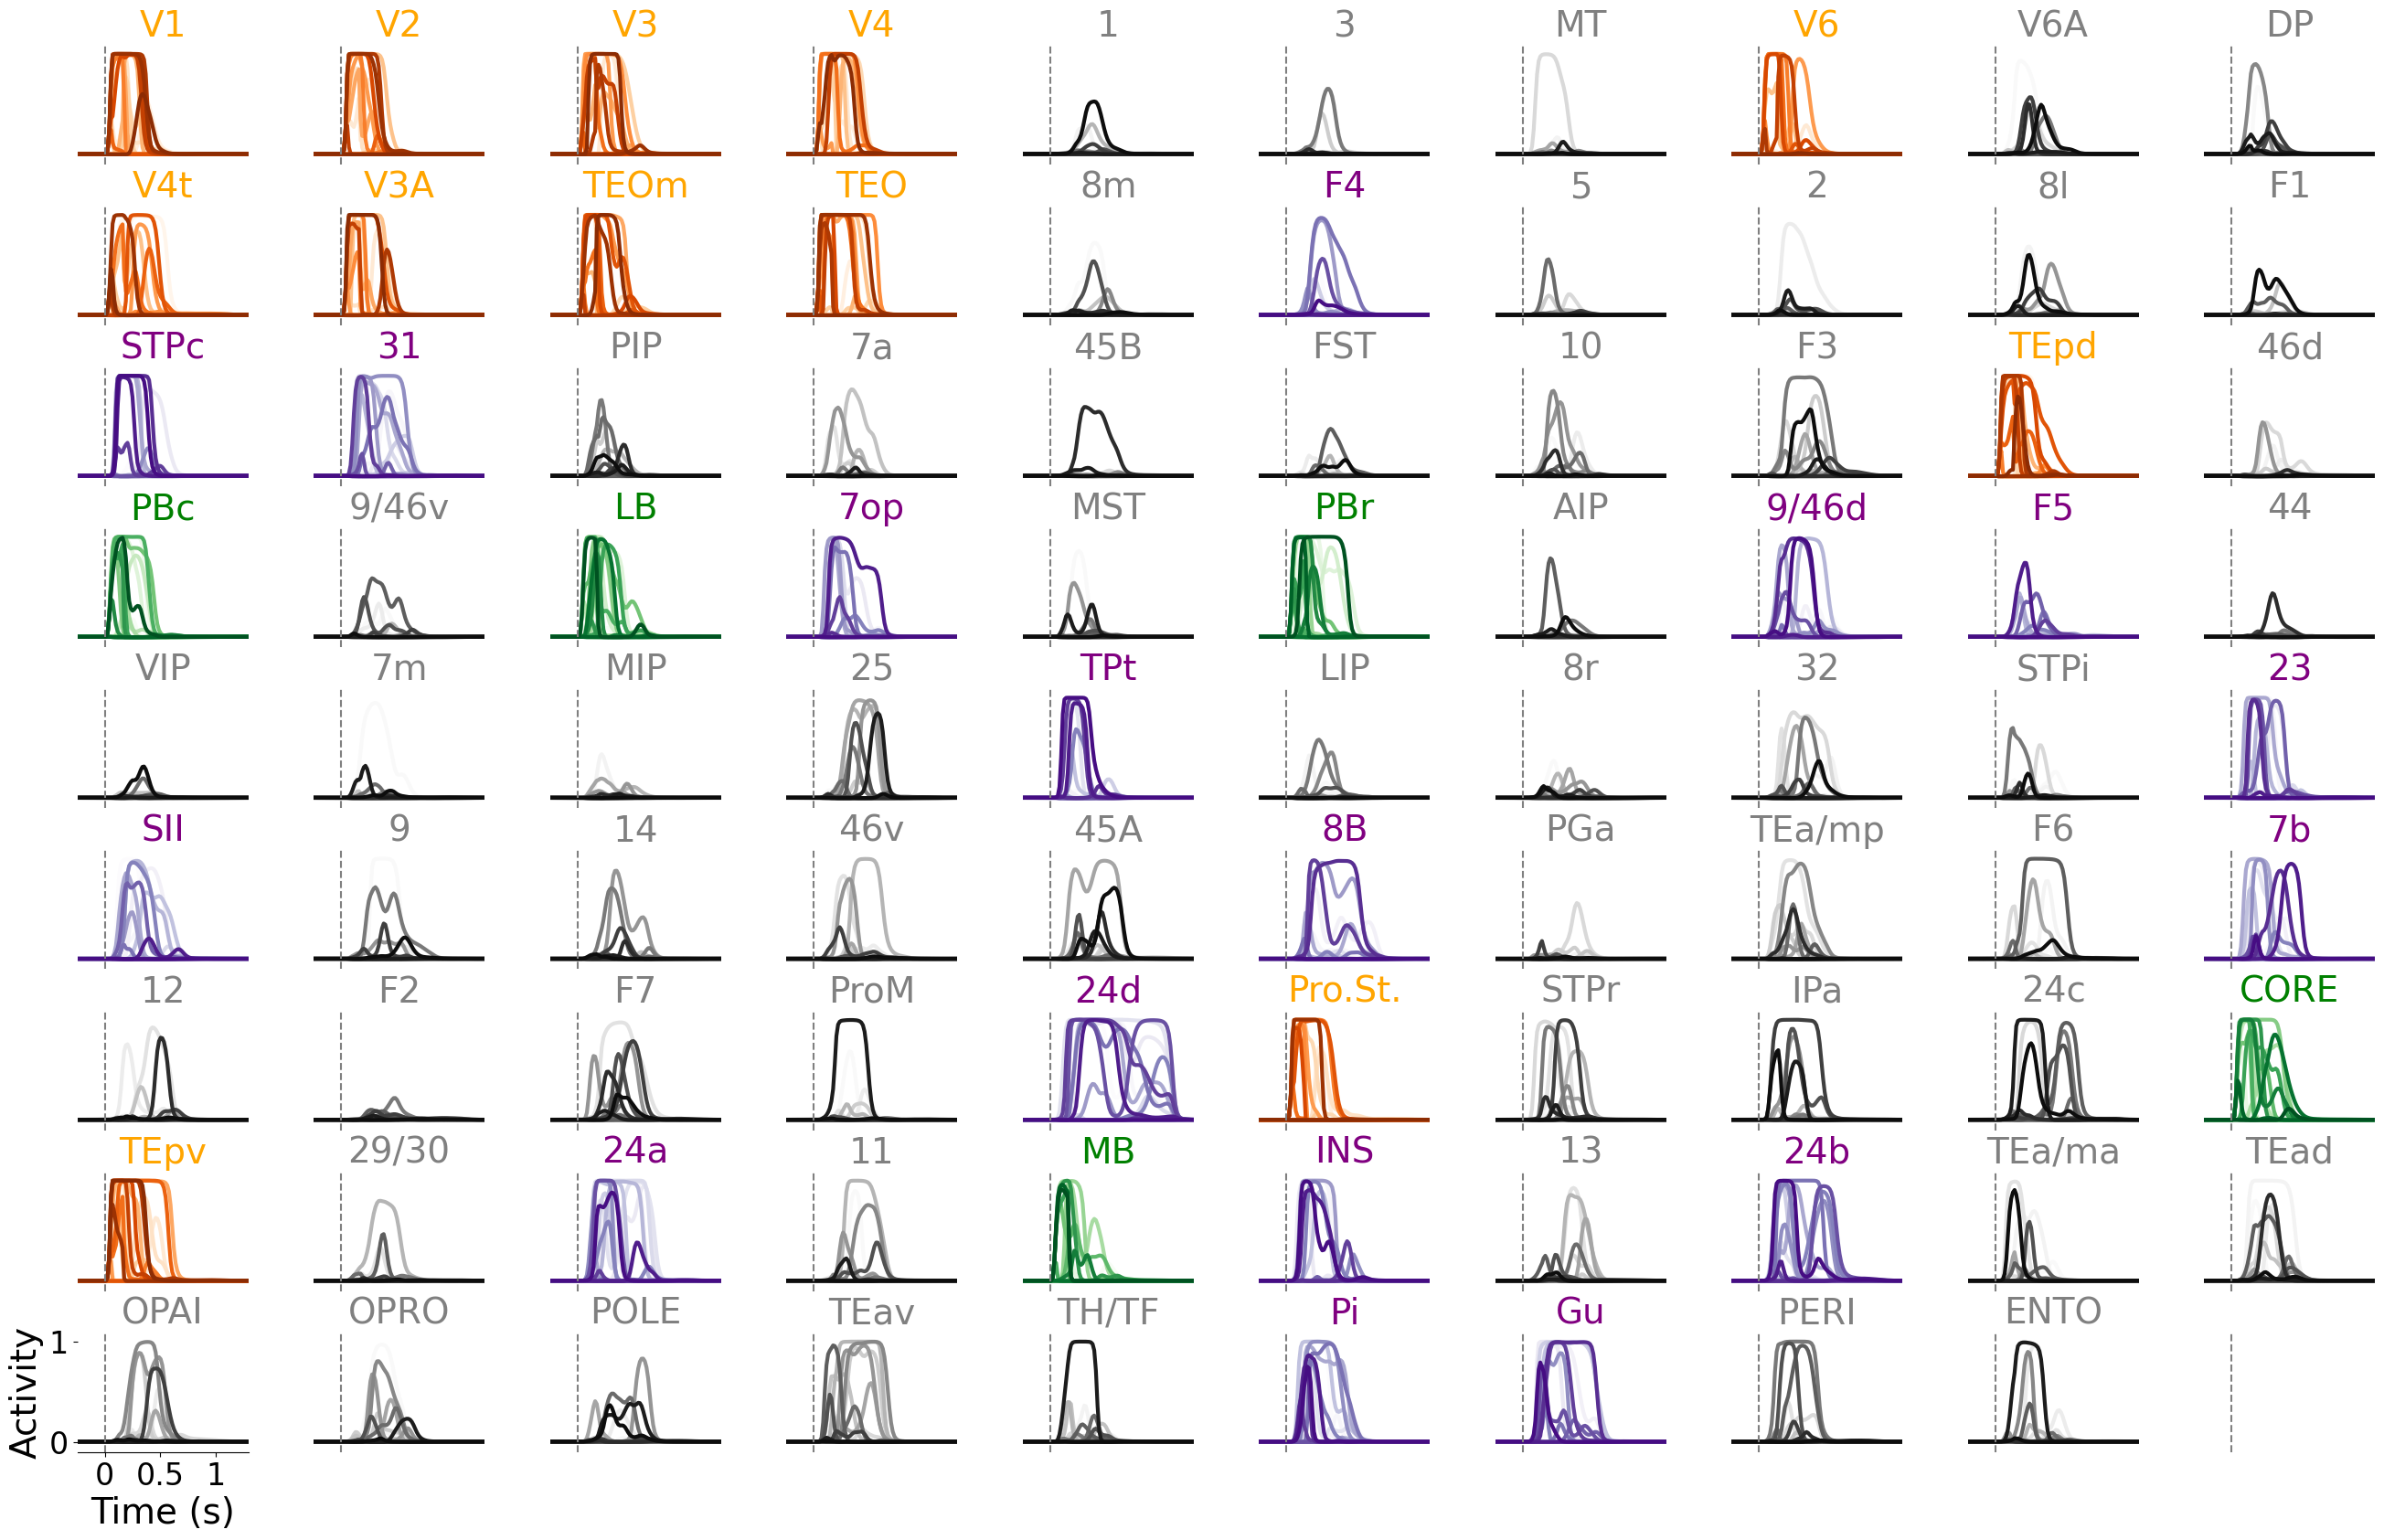

In [136]:
names_ctx = connectivity_params['names_ctx']
#results = pickle.load(open('data/gradient_chaos/sim_0.011.p', 'rb'))
time = results_seq['time']
r_ctx = results_seq['rates_ctx']
name = 'figures/S_sequences_visual_rates.pdf'

lw_ov = 2
lw_fr = 3


ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 24

fs=28
N_block = modelparams['N_block'] # resolution saved nurons 
N_recorded = modelparams['N_recorded'] # resolution saved nurons 
N_neu =int( N_block/int(N_block/N_recorded)) #number recorded neurons
colors = plt.cm.hsv(np.linspace(0,1, N_neu))
names_ctx, inds_full = names_inds_ctx()
dt = modelparams['dt']
t_start = modelparams['t_start']
#ind_start = int(t_start/dt)
t_stop = t_start + 1.3
t_end = t_stop



colors_oranges = plt.cm.Oranges(np.linspace(0,1, N_neu))
colors_greens = plt.cm.Greens(np.linspace(0,1, N_neu))
colors_greys = plt.cm.Greys(np.linspace(0, 1 , N_neu))
colors_purples = plt.cm.Purples(np.linspace(0, 1 , N_neu))

# plotting altoghether 
fig, ax = plt.subplots(figsize=(26, 16),nrows=9, ncols=10)
fig.tight_layout()
l=0
n_row= 0
for row in ax:
    n_col=0
    for col in row:
        if l<=88:
            ind_1 = l * N_neu
            ind_2 = (l+1) * N_neu
            #col.set_prop_cycle(cycler('color', colors))
            if l in subnetworks['Visual']:
                color = 'orange'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_oranges[k - l* N_neu])
            elif l in subnetworks['Salience']:
                color = 'purple'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_purples[k - l* N_neu])
            elif l in auditory:
                color = 'green'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_greens[k - l* N_neu])
            else:
                color = 'grey'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_greys[k - l* N_neu])
            col.set_title(names_ctx[l],fontsize = fs, color = color)
        col.set_ylim([-.1,1.1])
        col.set_xlim([t_start-.25, t_end])
        col.axvline(x=t_start, ymin=0, ymax=200, ls = '--',color='gray')
        if n_col!=0:
            col.set_yticks([])
            col.set_xticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
        if n_row!=8:
            col.set_xticks([])
            col.set_yticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
        if n_col==0 and n_row==8:
            col.set_ylabel('Activity', fontsize =fs)
            col.set_yticks([0, 1])
            col.set_yticklabels([0, 1], fontsize = s_ticks)
            col.set_xlabel('Time (s)', fontsize = fs)
            col.set_xticks([ t_start, t_start+0.5, t_start+1])
            col.set_xticklabels([0,  0.5, 1], fontsize = s_ticks)
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)

        l+=1
        n_col+=1
    n_row+=1
    #plt.savefig(name, bbox_inches='tight')
plt.savefig(name, bbox_inches='tight')


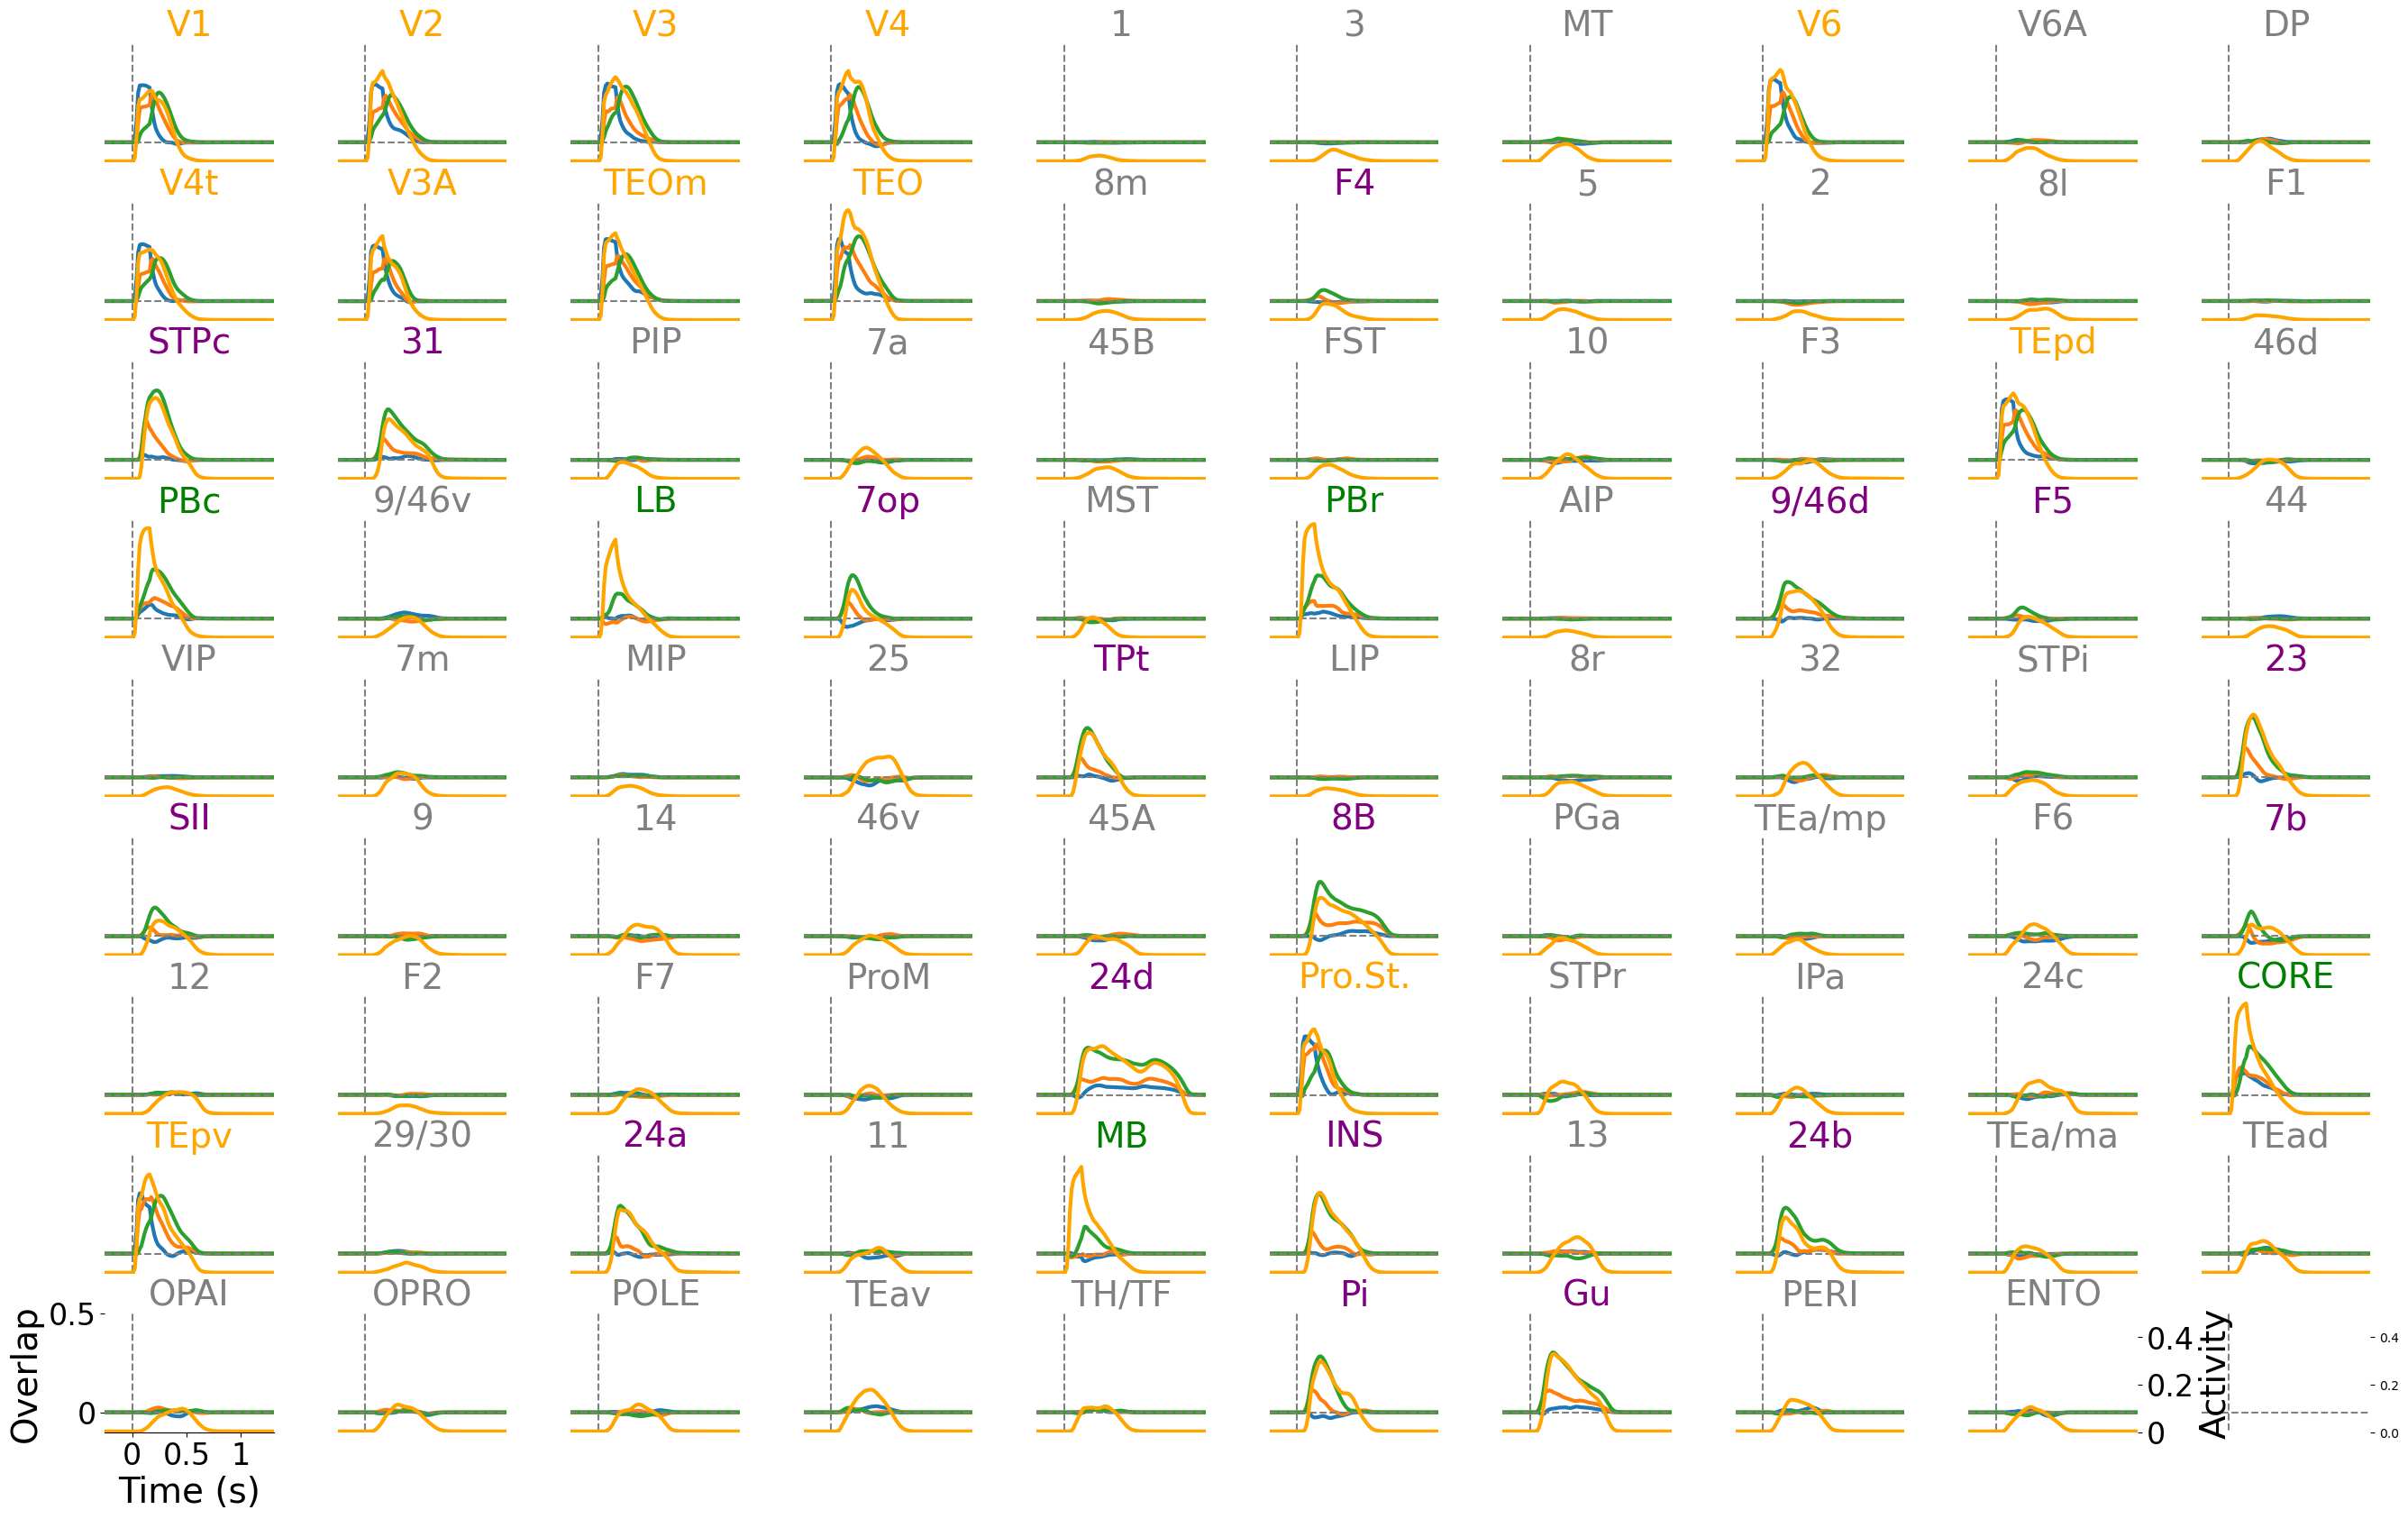

In [137]:
names_ctx = connectivity_params['names_ctx']
time = results_seq['time']
r_ctx = results_seq['rates_ctx']
overlaps = results_seq['overlaps_sym']


name_grad = 'figures/S_sequences_visual_overlaps.pdf'

lw_ov = 3
lw_fr = 3


ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 24
colors_overlaps = plt.cm.Dark2(np.linspace(0,1, 8))

fs=28

N_block = modelparams['N_block']
p = overlaps.shape[2]
colors = plt.cm.hsv(np.linspace(0,1,N_block))
names_ctx, inds_full = names_inds_ctx()
dt = modelparams['dt']
t_start = modelparams['t_start']
#ind_start = int(t_start/dt)
t_stop = t_start + 1.3
#ind_end = int(t_stop/dt)

t_end = t_stop

colors = ['b', 'r']
fig, ax = plt.subplots(figsize=(26, 16),nrows=9, ncols=10)
fig.tight_layout()
l=0
n_row= 0
for row in ax:
    n_col=0
    for col in row:
        if l<89:
            #for s in range(p):
            if l in subnetworks['Salience']:
                color = 'purple'
            elif l in subnetworks['Visual']:
                color = 'orange'
            elif l in auditory:
                color = 'green'
            else:
                color = 'grey'
            col.plot(time, overlaps[:, l, 0, :], lw =lw_ov, color = 'b')
            col.set_title(names_ctx[l],fontsize = fs, color = color)
            axij = col.twinx()
            r_mean = np.mean(r_ctx[:, l * N_neu: (l + 1)* N_neu], axis = 1)
            axij.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
            axij.set_ylim([0,.5])
        col.set_ylim([-.1,0.5])
        col.set_xlim([t_start-0.25, t_end])
        col.axhline(y=0, xmin=0, xmax=400, ls = '--',color='gray')
        col.axvline(x=t_start, ymin=-2, ymax=2, ls = '--',color='gray')
        if n_col!=0:
            col.set_yticks([])
            col.set_xticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
            axij.spines['right'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['bottom'].set_visible(False)
            axij.set_yticks([])
            axij.set_xticks([])
        if n_row!=8:
            col.set_xticks([])
            col.set_yticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
        if n_row==8 and n_col==0:
            col.set_ylabel('Overlap', fontsize =fs)
            col.set_yticks([0, 0.5])
            col.set_yticklabels([0, 0.5], fontsize = s_ticks)
        
            col.set_xlabel('Time (s)', fontsize = fs)
            col.set_xticks([t_start, t_start+0.5, t_start+1])
            col.set_xticklabels([0, 0.5,1], fontsize = s_ticks)
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
        if n_col != 9:
            axij.spines['right'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['bottom'].set_visible(False)
            axij.set_yticks([])
        if n_col==9 and n_row==8:
            axij.set_yticks([0, 0.2, 0.4])
            axij.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)
            axij.spines['bottom'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['right'].set_visible(False)
            axij.set_ylabel('Activity', fontsize =fs)
        
            col.plot(time, -20 * time -1, lw =lw_ov, color = 'blue')
            axij = col.twinx()
            axij.plot(time,  -20 * time - 1, color = m_fr_color, lw= lw_ov)
            col.set_ylim([-.1,0.5])
            axij.set_ylim([0,.5])
            axij.spines['right'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['bottom'].set_visible(False)
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
            col.set_xticks([])
            col.set_yticks([])
            col.set_xlabel('', fontsize = fs)
 
            
        l+=1
        n_col+=1
    n_row+=1
#plt.savefig(str_ov, bbox_inches='tight')
#plt.close()
plt.savefig(name_grad, bbox_inches='tight')

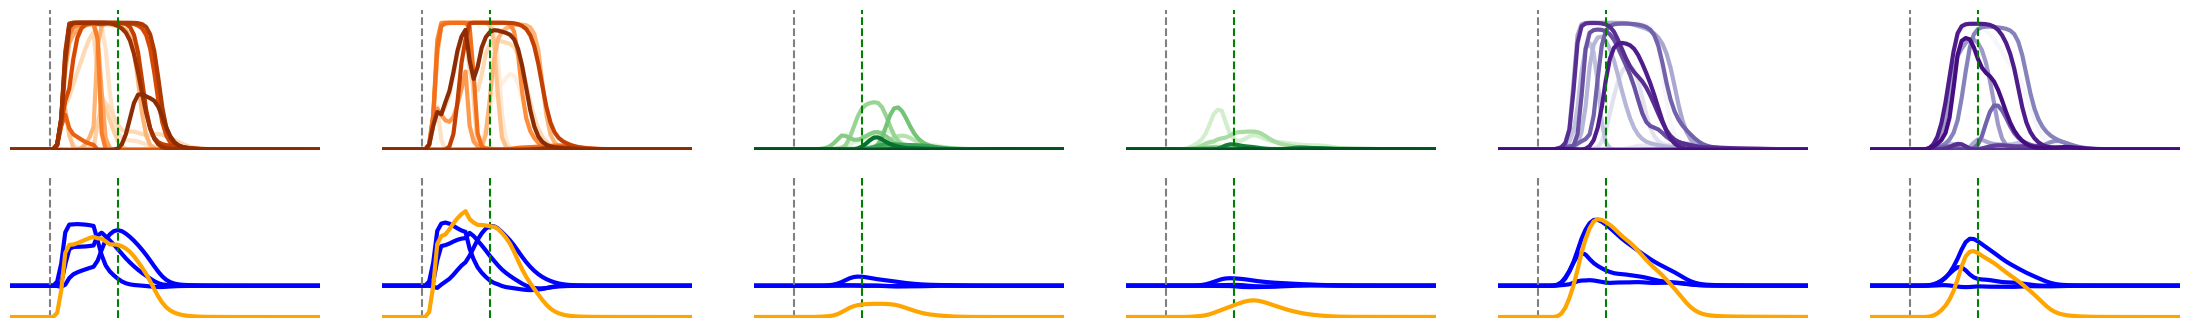

In [112]:
#hereee

time = results_seq['time']
r_ctx = results_seq['rates_ctx']
overlaps = results_seq['overlaps_sym']


ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 28
lw_fr = 3 
lw_ov = 3

dt = modelparams['dt']
t_start = modelparams['t_start']
deltat = modelparams['t_stim'] #time before stimulus
t_stop = t_start + 1
t_end = t_stop


colors_oranges = plt.cm.Oranges(np.linspace(0,1, N_neu))
colors_purples = plt.cm.Purples(np.linspace(0, 1 , N_neu))
colors_greens = plt.cm.Greens(np.linspace(0, 1 , N_neu))

fig, ax = plt.subplots(figsize=(28, 4),nrows=2, ncols=6)

dN = 10
s = 0
#frist column
color_obs = 'green'
x_obs = t_start+0.25
ind1 = names_ctx.index('V1')
for l in range(ind1* N_neu, (ind1+1)* N_neu, dN):
    ax[0,0].plot(time, r_ctx[:, l], color = colors_oranges[l-ind1* N_neu], lw= lw_fr)
ax[0,0].set_ylim([0,1.1])
ax[0,0].set_xticks([])
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['bottom'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].set_xlim([t_start-deltat, t_end])
ax[0,0].set_yticks([])
#ax[0,0].set_yticks([0, 0.5, 1])
#ax[0,0].set_yticklabels([0, 0.5, 1], fontsize = s_ticks)
ax[0,0].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,0].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )


#for k in range(overlaps.shape[3]):
ax[1,0].plot(time, overlaps[:, ind1, s, :], color = 'b', lw= lw_ov)
ax[1,0].set_ylim([-.15,0.5])
ax[1,0].set_xlim([t_end - 2, t_end])
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].spines['bottom'].set_visible(False)
ax[1,0].set_xlim([t_start-deltat, t_end])
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
#ax[1,0].set_xticks([t_start, t_start+0.5, t_start+1])
#ax[1,0].set_xticklabels([ 0,  0.5, 1], fontsize = s_ticks)
#ax[1,0].set_yticks([0, 0.2, 0.4])
#ax[1,0].set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)
ax[1,0].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,0].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )

ax10 = ax[1,0].twinx()
r_mean1 = np.mean(r_ctx[:, ind1* N_neu: (ind1+1)* N_neu], axis = 1)
ax10.plot(time,  r_mean1, color = m_fr_color, lw= lw_ov)
ax10.set_ylim([0,0.5])
ax10.set_xlim([t_start-deltat, t_end])
ax10.set_xticks([t_start, t_start+0.5, t_start+1])
ax10.set_xticklabels([0,  0.5, 1], fontsize = s_ticks)
ax10.spines['right'].set_visible(False)
ax10.spines['top'].set_visible(False)
ax10.spines['bottom'].set_visible(False)
ax10.spines['left'].set_visible(False)
ax10.set_yticks([])
ax10.set_xticks([])

#second column

ind2 = names_ctx.index('V4') 
for l in range(ind2* N_neu, (ind2+1)* N_neu, dN):
    ax[0,1].plot(time, r_ctx[:, l],  color = colors_oranges[l - ind2* N_neu], lw= lw_fr)
ax[0,1].set_ylim([0,1.1])
ax[0,1].set_xticks([])
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].spines['bottom'].set_visible(False)
ax[0,1].set_xlim([t_start-deltat, t_end])
ax[0,1].set_yticks([])
ax[0,1].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,1].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )




ax[1,1].plot(time, overlaps[:, ind2, s, :], color = 'b', lw= lw_ov)
#ax[1,1].plot(time, overlaps[:, ind2, 0], color = ov_color, lw= lw_ov)
ax[1,1].set_ylim([-.15,0.5])
ax[1,1].set_xlim([t_end - 2, t_end])
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].spines['bottom'].set_visible(False)
ax[1,1].set_yticks([])
ax[1,1].set_xlim([t_start-deltat, t_end])
ax[1,1].set_xticks([])
#ax[1,1].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,1].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1,1].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,1].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )



ax11 = ax[1,1].twinx()
r_mean = np.mean(r_ctx[:, ind2 * N_neu: (ind2+1) * N_neu], axis = 1)
ax11.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax11.set_ylim([0,0.5])
ax11.set_xlim([t_start-deltat, t_end])
ax11.set_xticks([])
#ax11.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax11.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax11.spines['top'].set_visible(False)
ax11.spines['left'].set_visible(False)
ax11.spines['right'].set_visible(False)
ax11.spines['bottom'].set_visible(False)
ax11.set_yticks([])

#third column

ind3 =  names_ctx.index('LB')#
for l in range(ind3* N_neu, (ind3+1)* N_neu, dN):
    ax[0,2].plot(time, r_ctx[:, l], color = colors_greens[l-ind3* N_neu], lw=lw_fr)
ax[0,2].set_ylim([0,1.1])
ax[0,2].set_xticks([])
ax[0,2].spines['right'].set_visible(False)
ax[0,2].spines['top'].set_visible(False)
ax[0,2].spines['left'].set_visible(False)
ax[0,2].spines['bottom'].set_visible(False)
ax[0,2].set_yticks([])
ax[0,2].set_xlim([t_start-deltat, t_end])
ax[0,2].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,2].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )

ax[1,2].plot(time, overlaps[:, ind3, s, :], color = 'b', lw= lw_ov)
ax[1,2].set_ylim([-.15,0.5])
ax[1,2].spines['right'].set_visible(False)
ax[1,2].spines['top'].set_visible(False)
ax[1,2].spines['left'].set_visible(False)
ax[1,2].spines['bottom'].set_visible(False)
ax[1,2].set_yticks([])
ax[1,2].set_xlim([t_start-deltat, t_end])
ax[1,2].set_xticks([])
#ax[1,2].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,2].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1,2].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,2].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )

ax12 = ax[1,2].twinx()
r_mean = np.mean(r_ctx[:, ind3* N_neu: (ind3+1)* N_neu], axis = 1)
ax12.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax12.set_ylim([0,.5])
ax12.set_xlim([t_start-deltat, t_end])
ax12.set_xticks([])
#ax12.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax12.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
#ax12.spines['right'].set_visible(False)
ax12.spines['top'].set_visible(False)
ax12.spines['left'].set_visible(False)
ax12.spines['right'].set_visible(False)
ax12.spines['bottom'].set_visible(False)
ax12.set_yticks([])
#ax12.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)


#4th column
ind3 = names_ctx.index('PBr')#
for l in range(ind3* N_neu, (ind3+1)* N_neu, dN):
    ax[0,3].plot(time, r_ctx[:, l], color = colors_greens[l-ind3* N_neu], lw=lw_fr)
ax[0,3].set_ylim([0,1.1])
ax[0,3].set_xticks([])
ax[0,3].spines['right'].set_visible(False)
ax[0,3].spines['top'].set_visible(False)
ax[0,3].spines['left'].set_visible(False)
ax[0,3].spines['bottom'].set_visible(False)
ax[0,3].set_yticks([])
ax[0,3].set_xlim([t_start-deltat, t_end])
ax[0,3].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,3].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )

ax[1,3].plot(time, overlaps[:, ind3, s, :], color = 'b', lw= lw_ov)
#ax[1,3].plot(time, overlaps[:, ind3, 1], color = ov_color, lw= lw_ov)
ax[1,3].set_ylim([-.15,0.5])
ax[1,3].set_xlim([t_start-deltat, t_end])
ax[1,3].set_xticks([])
#ax[1,3].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,3].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1,3].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,3].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )
ax[1,3].spines['right'].set_visible(False)
ax[1,3].spines['top'].set_visible(False)
ax[1,3].spines['left'].set_visible(False)
ax[1,3].spines['bottom'].set_visible(False)
ax[1,3].set_yticks([])


ax13 = ax[1,3].twinx()
r_mean = np.mean(r_ctx[:, ind3* N_neu: (ind3+1)* N_neu], axis = 1)
ax13.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax13.set_ylim([0,.5])
ax13.set_xlim([t_start-deltat, t_end])
ax13.set_xticks([])
#ax13.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax13.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax13.spines['top'].set_visible(False)
ax13.spines['left'].set_visible(False)
ax13.spines['right'].set_visible(False)
ax13.spines['bottom'].set_visible(False)
ax13.set_yticks([])


#5th column

ind3 = names_ctx.index('23')
for l in range(ind3* N_neu, (ind3+1)* N_neu, dN):
    ax[0,4].plot(time, r_ctx[:, l], color = colors_purples[l-ind3* N_neu], lw=lw_fr)
ax[0,4].set_ylim([0,1.1])
ax[0,4].set_xticks([])
ax[0,4].spines['right'].set_visible(False)
ax[0,4].spines['top'].set_visible(False)
ax[0,4].spines['left'].set_visible(False)
ax[0,4].spines['bottom'].set_visible(False)
ax[0,4].set_xlim([t_start-deltat, t_end])
ax[0,4].set_yticks([])
ax[0,4].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,4].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )


ax[1,4].plot(time, overlaps[:, ind3, s, :], color = 'b', lw= lw_ov)
ax[1,4].set_ylim([-.15,0.5])
ax[1,4].set_xlim([t_end - 2, t_end])
ax[1,4].spines['right'].set_visible(False)
ax[1,4].spines['top'].set_visible(False)
ax[1,4].spines['left'].set_visible(False)
ax[1,4].spines['bottom'].set_visible(False)
ax[1,4].set_yticks([])
ax[1,4].set_xlim([t_start-deltat, t_end])
ax[1,4].set_xticks([])
#ax[1,4].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,4].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1,4].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,4].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )


ax14 = ax[1,4].twinx()
r_mean = np.mean(r_ctx[:, ind3* N_neu: (ind3+1)* N_neu], axis = 1)
ax14.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax14.set_ylim([0,.5])
ax14.set_xlim([t_start-deltat, t_end])
ax14.set_xticks([])
#ax14.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax14.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax14.spines['right'].set_visible(False)
ax14.spines['top'].set_visible(False)
ax14.spines['left'].set_visible(False)
ax14.spines['bottom'].set_visible(False)
ax14.set_yticks([])

#6th column
ind6 = names_ctx.index('INS')
for l in range(ind6 * N_neu, (ind6 + 1)* N_neu, dN):
    ax[0,5].plot(time, r_ctx[:, l], color = colors_purples[l-ind6* N_neu], lw=lw_fr)
ax[0,5].set_ylim([0,1.1])
ax[0,5].set_xticks([])
ax[0,5].spines['right'].set_visible(False)
ax[0,5].spines['top'].set_visible(False)
ax[0,5].spines['left'].set_visible(False)
ax[0,5].spines['bottom'].set_visible(False)
ax[0,5].set_xlim([t_start-deltat, t_end])
ax[0,5].set_yticks([])
ax[0,5].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,5].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )

ax[1,5].plot(time, overlaps[:, ind6, s, :], color = 'b', lw= lw_ov)
ax[1,5].set_ylim([-.15,0.5])
ax[1,5].set_xlim([t_end - 2, t_end])
ax[1,5].spines['right'].set_visible(False)
ax[1,5].spines['top'].set_visible(False)
ax[1,5].spines['left'].set_visible(False)
ax[1,5].spines['bottom'].set_visible(False)
ax[1,5].set_yticks([])
ax[1,5].set_xlim([t_start-deltat, t_end])
ax[1,5].set_xticks([])
#ax[1,5].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,5].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1,5].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,5].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )
#ax[1,5].axhline(y=0, xmin=0, xmax=400, ls = '--',color='gray')

ax15 = ax[1,5].twinx()
r_mean = np.mean(r_ctx[:, ind6 * N_neu: (ind6 + 1)* N_neu], axis = 1)
ax15.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax15.set_ylim([0,.5])
ax15.set_xlim([t_start-deltat, t_end])
ax15.set_xticks([])
#ax15.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax15.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
#ax12.spines['right'].set_visible(False)
ax15.spines['top'].set_visible(False)
ax15.spines['left'].set_visible(False)
ax15.spines['bottom'].set_visible(False)
ax15.spines['right'].set_visible(False)
#ax15.set_yticks([0, 0.2, 0.4])
#ax15.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)
ax15.set_yticks([])



plt.savefig('figures/panels/salience_visual.pdf', bbox_inches='tight')

In [113]:
if True:
    #save as mat file
    overlaps = results_seq['overlaps_sym'][:,:,0,:]
    sio.savemat('results/overlaps_salient_visual.mat', {'overlaps_salient_visual':overlaps})
    r_ctx = results_seq['rates_ctx']
    N_block = modelparams['N_block'] # resolution saved nurons 
    N_recorded = modelparams['N_recorded'] # resolution saved nurons 
    N_neu =int( N_block/int(N_block/N_recorded)) #number recorded neurons
    mean_rates = []
    for l in range(89):
        r_mean = np.mean(r_ctx[:, l * N_neu: (l + 1)* N_neu], axis = 1)
        mean_rates.append(r_mean)
    mean_rates = np.array(mean_rates)
    sio.savemat('results/mean_rate_salient_visual.mat', {'rate_salient_visual':mean_rates})




In [114]:
s = 0 #aymmetric patterns
network.overlaps.is_sym = False
task.i_pat = np.zeros(task.i_pat.shape)
task.ind_stim=np.array(auditory)
task.ind_asym = 0
task.pat_input(ind_pat = 1)
network.input_ctx = task.input_current

#network.which_tf = 'sig'

#running dynamics
s0_ctx =  0 * np.random.uniform(0,.1, network.mat.shape[0])
amp_in = 0
for l in inds[s]:
    Nl = l * connectivity.N
    Nlp1 = (l + 1) * connectivity.N
    s0_ctx[Nl : Nlp1] = amp_in * connectivity.hebbian_symmetric.patterns_current_asym[l, :, s, 0]
results_seq = network.dynamics(s0_ctx)

Simulation t= 0.0
Simulation t= 0.015
Simulation t= 0.03
Simulation t= 0.045
Simulation t= 0.06
Simulation t= 0.075
Simulation t= 0.09
Simulation t= 0.105
Simulation t= 0.12
Simulation t= 0.135
Simulation t= 0.15
Simulation t= 0.165
Simulation t= 0.18
Simulation t= 0.195
Simulation t= 0.21
Simulation t= 0.225
Simulation t= 0.24
Simulation t= 0.255
Simulation t= 0.27
Simulation t= 0.285
Simulation t= 0.3
Simulation t= 0.315
Simulation t= 0.33
Simulation t= 0.345
Simulation t= 0.36
Simulation t= 0.375
Simulation t= 0.39
Simulation t= 0.405
Simulation t= 0.42
Simulation t= 0.435
Simulation t= 0.45
Simulation t= 0.465
Simulation t= 0.48
Simulation t= 0.495
Simulation t= 0.51
Simulation t= 0.525
Simulation t= 0.54
Simulation t= 0.555
Simulation t= 0.57
Simulation t= 0.585
Simulation t= 0.6
Simulation t= 0.615
Simulation t= 0.63
Simulation t= 0.645
Simulation t= 0.66
Simulation t= 0.675
Simulation t= 0.69
Simulation t= 0.705
Simulation t= 0.72
Simulation t= 0.735
Simulation t= 0.75
Simulatio

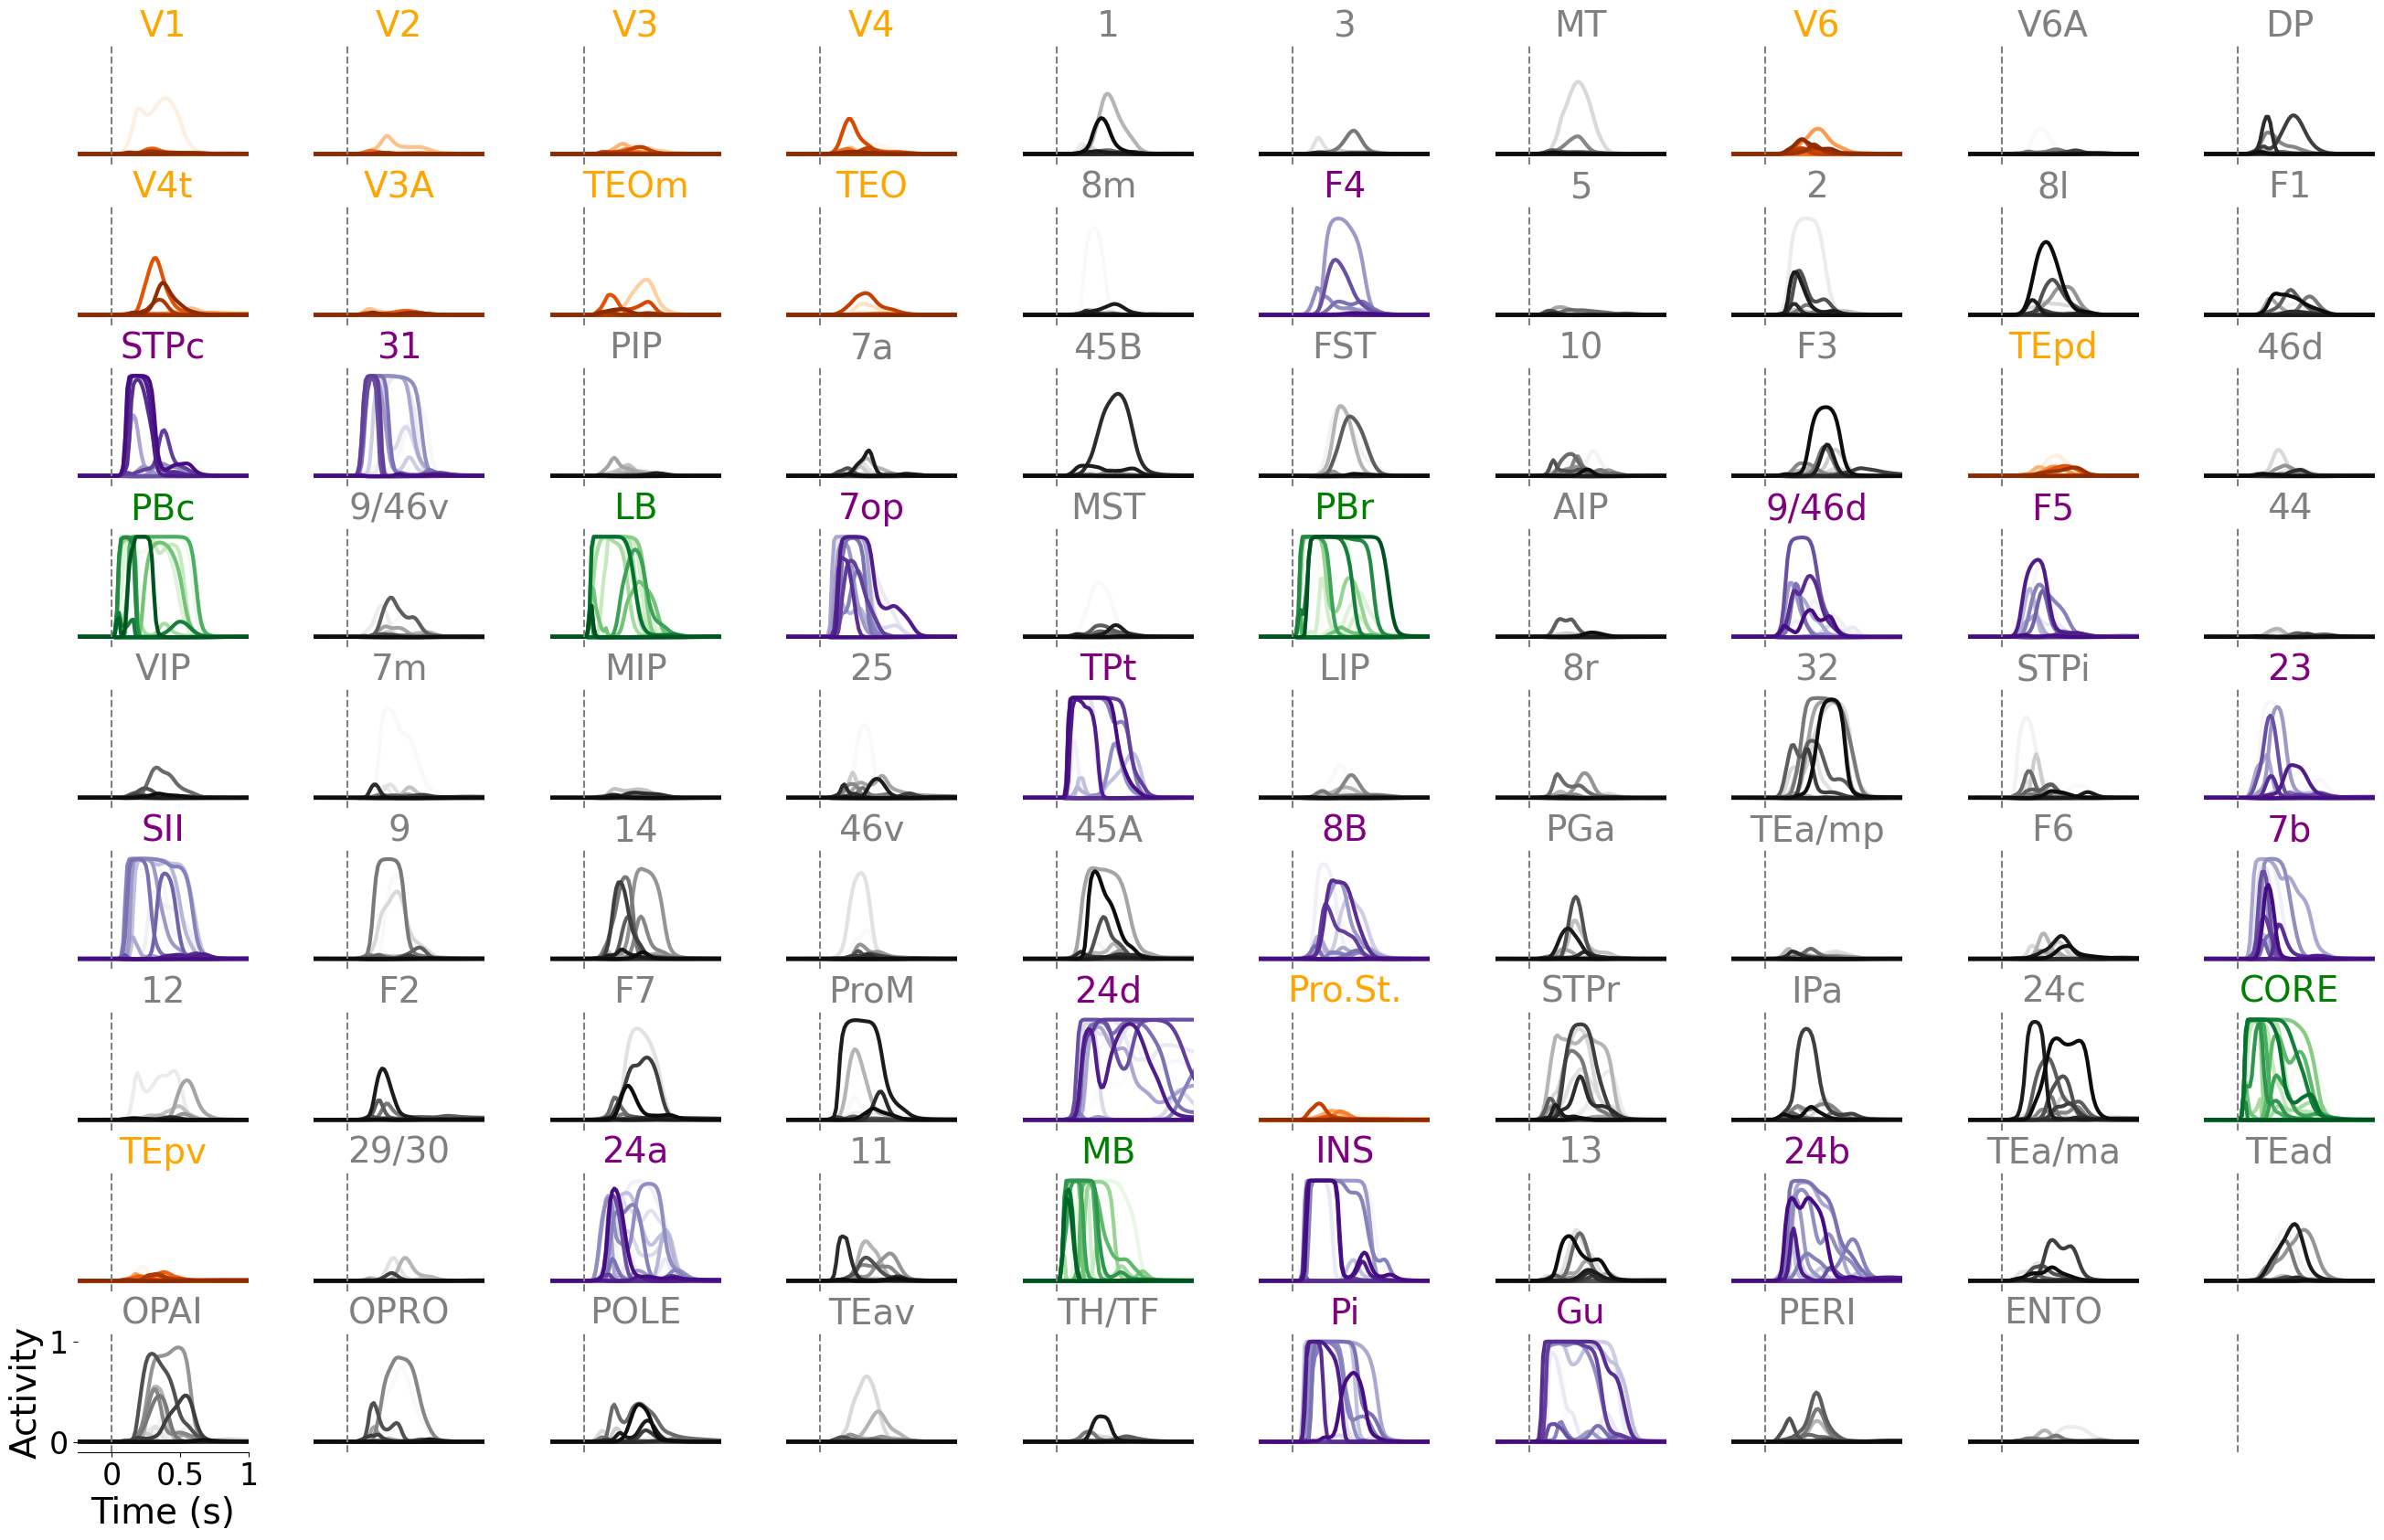

In [99]:
names_ctx = connectivity_params['names_ctx']
#results = pickle.load(open('data/gradient_chaos/sim_0.011.p', 'rb'))
time = results_seq['time']
r_ctx = results_seq['rates_ctx']
name = 'figures/S_sequences_auditory_rates.pdf'

lw_ov = 2
lw_fr = 3


ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 24

fs=28
N_block = modelparams['N_block'] # resolution saved nurons 
N_recorded = modelparams['N_recorded'] # resolution saved nurons 
N_neu =int( N_block/int(N_block/N_recorded)) #number recorded neurons
colors = plt.cm.hsv(np.linspace(0,1, N_neu))
names_ctx, inds_full = names_inds_ctx()
dt = modelparams['dt']
t_start = modelparams['t_start']
t_stop = t_start + 1
t_end = t_stop




colors_oranges = plt.cm.Oranges(np.linspace(0,1, N_neu))
colors_greens = plt.cm.Greens(np.linspace(0,1, N_neu))
colors_greys = plt.cm.Greys(np.linspace(0, 1 , N_neu))
colors_purples = plt.cm.Purples(np.linspace(0, 1 , N_neu))

# plotting altoghether 
fig, ax = plt.subplots(figsize=(26, 16),nrows=9, ncols=10)
fig.tight_layout()
l=0
n_row= 0
for row in ax:
    n_col=0
    for col in row:
        if l<=88:
            ind_1 = l * N_neu
            ind_2 = (l+1) * N_neu
            #col.set_prop_cycle(cycler('color', colors))
            if l in subnetworks['Visual']:
                color = 'orange'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_oranges[k - l* N_neu])
            elif l in subnetworks['Salience']:
                color = 'purple'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_purples[k - l* N_neu])
            elif l in auditory:
                color = 'green'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_greens[k - l* N_neu])
            else:
                color = 'grey'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_greys[k - l* N_neu])
            col.set_title(names_ctx[l],fontsize = fs, color = color)
        col.set_ylim([-.1,1.1])
        col.set_xlim([t_start-.25, t_end])
        col.axvline(x=t_start, ymin=0, ymax=200, ls = '--',color='gray')
        if n_col!=0:
            col.set_yticks([])
            col.set_xticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
        if n_row!=8:
            col.set_xticks([])
            col.set_yticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
        if n_col==0 and n_row==8:
            col.set_ylabel('Activity', fontsize =fs)
            col.set_yticks([0, 1])
            col.set_yticklabels([0, 1], fontsize = s_ticks)
            col.set_xlabel('Time (s)', fontsize = fs)
            col.set_xticks([ t_start, t_start+0.5, t_start+1])
            col.set_xticklabels([0,  0.5, 1], fontsize = s_ticks)
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)

        l+=1
        n_col+=1
    n_row+=1
    #plt.savefig(name, bbox_inches='tight')
plt.savefig(name, bbox_inches='tight')

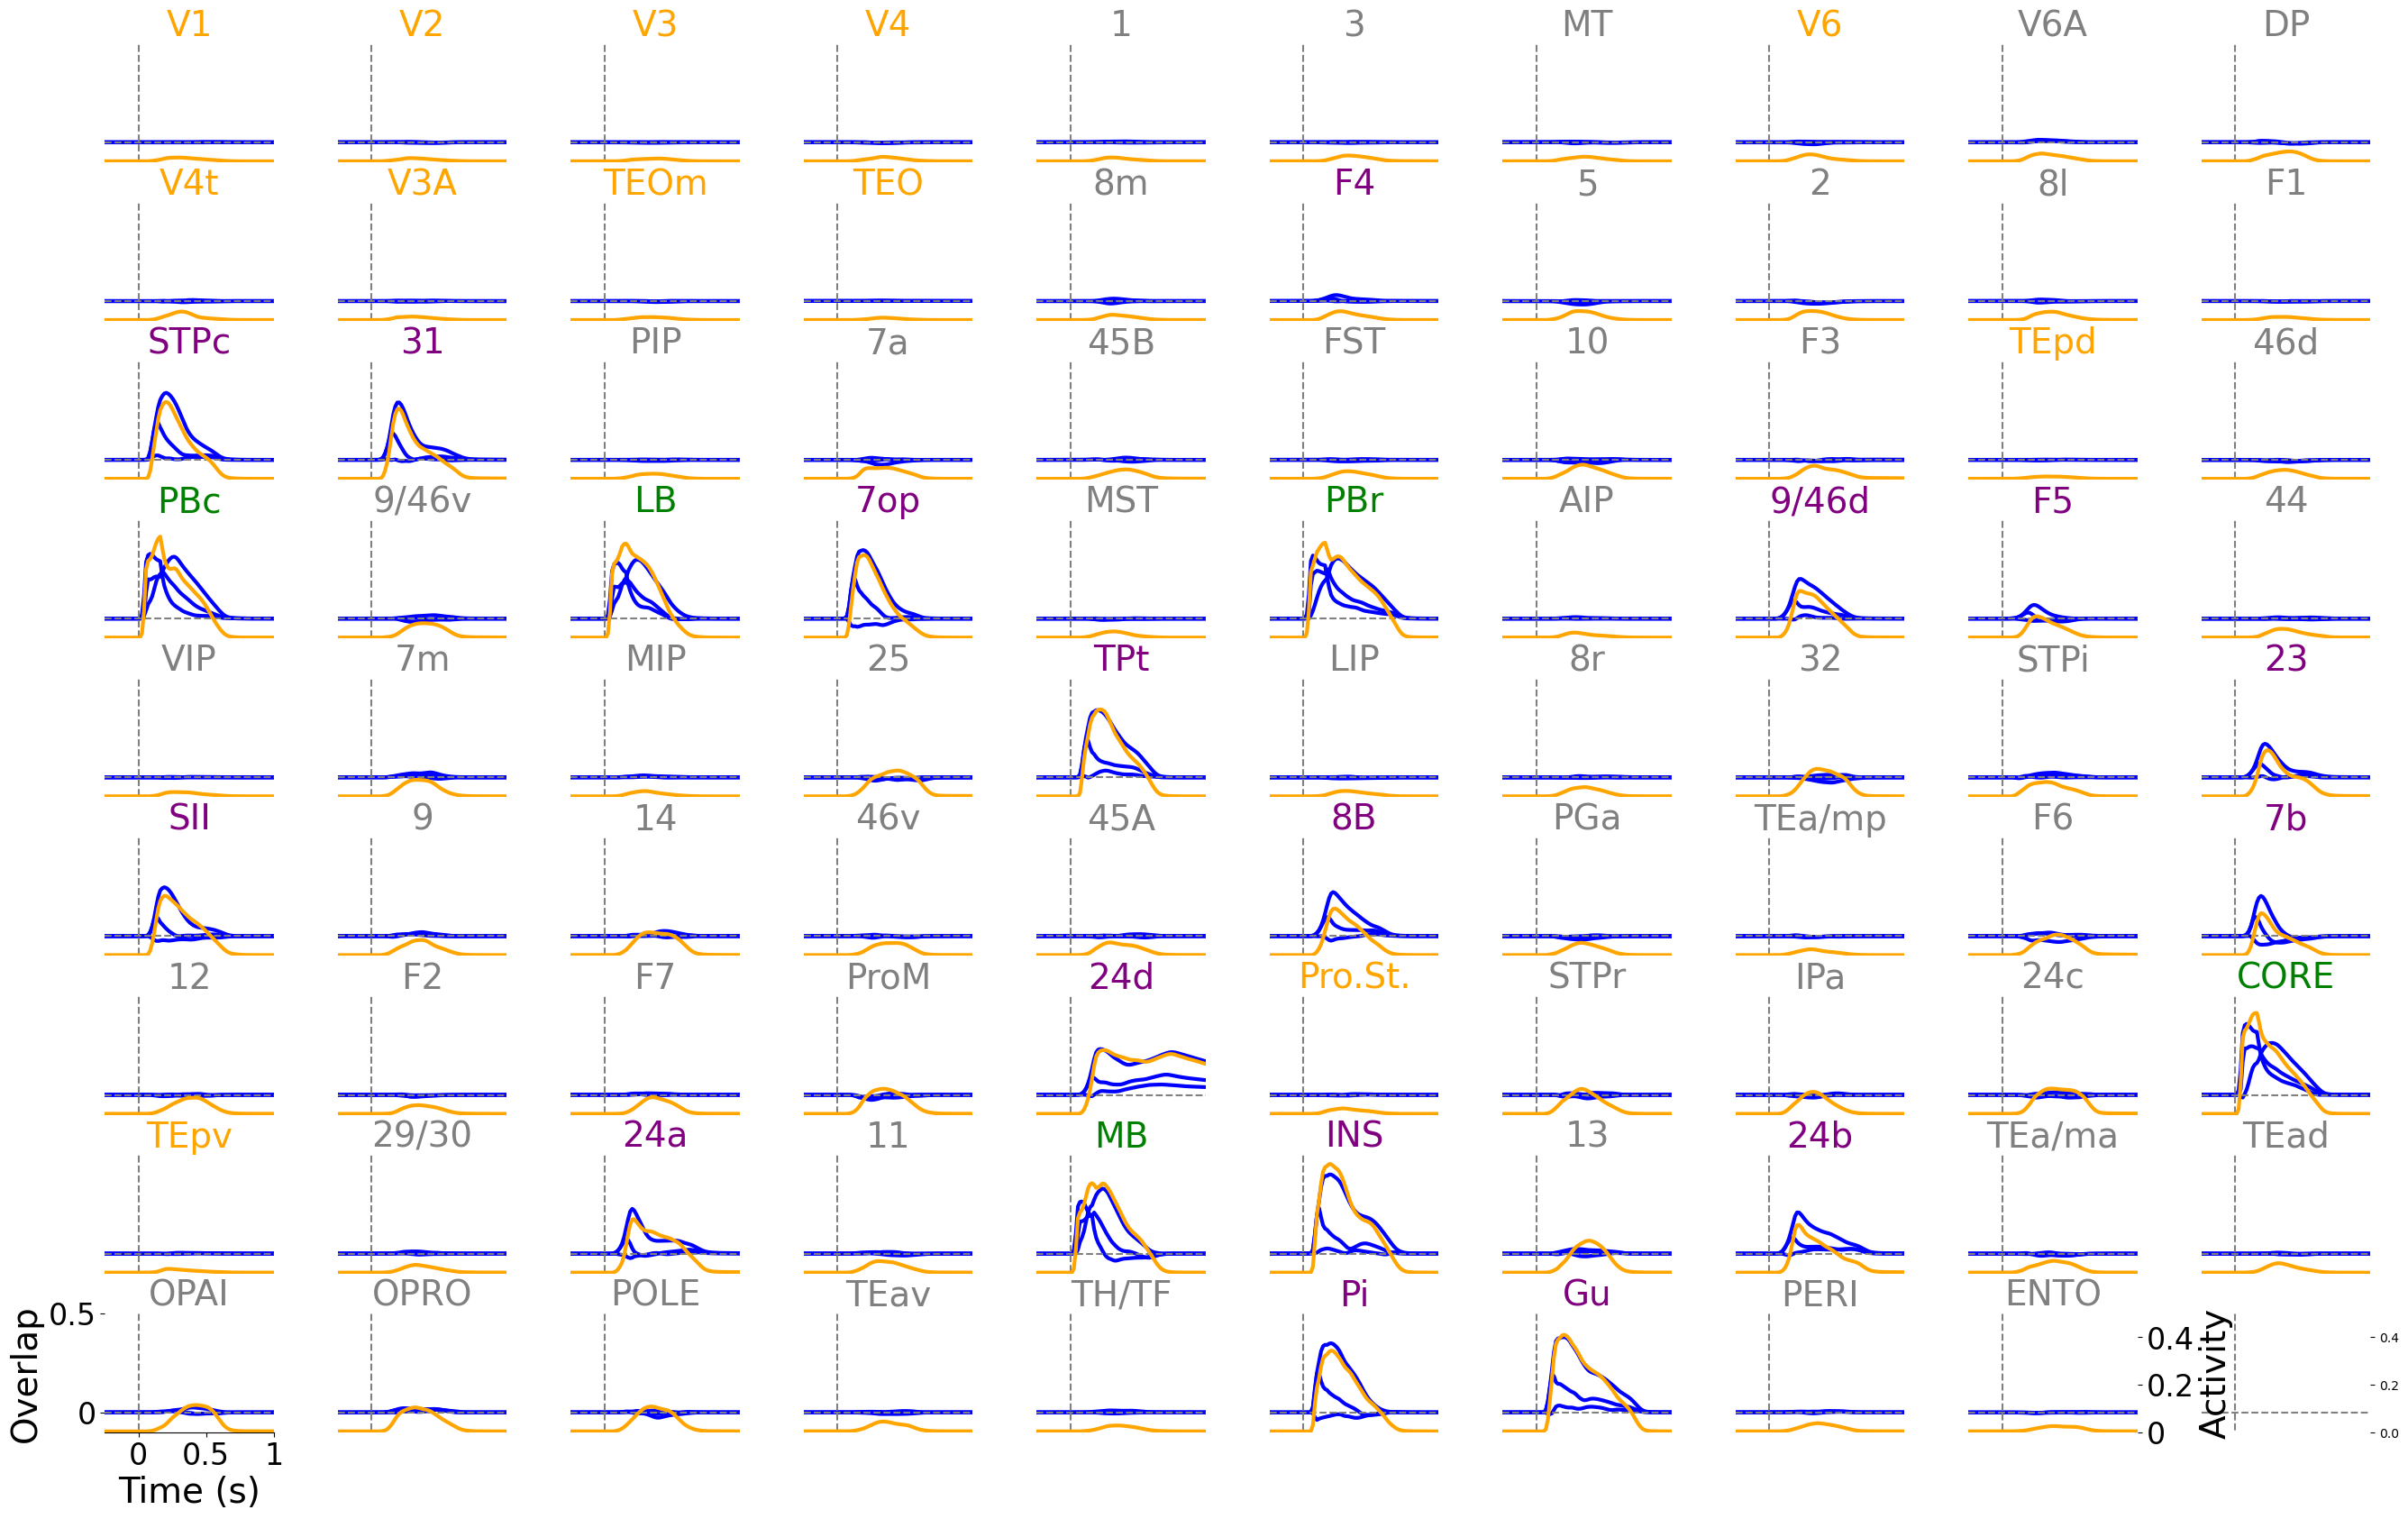

In [100]:
names_ctx = connectivity_params['names_ctx']
time = results_seq['time']
r_ctx = results_seq['rates_ctx']
overlaps = results_seq['overlaps_sym']


name_grad = 'figures/S_sequences_auditory_overlaps.pdf'

lw_ov = 3
lw_fr = 3


ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 24
colors_overlaps = plt.cm.Dark2(np.linspace(0,1, 8))

fs=28

N_block = modelparams['N_block']
p = overlaps.shape[2]
colors = plt.cm.hsv(np.linspace(0,1,N_block))
names_ctx, inds_full = names_inds_ctx()
dt = modelparams['dt']
t_start = modelparams['t_start']
t_stop = t_start + 1
t_end = t_stop


colors = ['b', 'r']
fig, ax = plt.subplots(figsize=(26, 16),nrows=9, ncols=10)
fig.tight_layout()
l=0
n_row= 0
for row in ax:
    n_col=0
    for col in row:
        if l<89:
            #for s in range(p):
            if l in subnetworks['Salience']:
                color = 'purple'
            elif l in subnetworks['Visual']:
                color = 'orange'
            elif l in auditory:
                color = 'green'
            else:
                color = 'grey'
            col.plot(time, overlaps[:, l, 0, :], lw =lw_ov, color = 'b')
            col.set_title(names_ctx[l],fontsize = fs, color = color)
            axij = col.twinx()
            r_mean = np.mean(r_ctx[:, l * N_neu: (l + 1)* N_neu], axis = 1)
            axij.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
            axij.set_ylim([0,.5])
        col.set_ylim([-.1,0.5])
        col.set_xlim([t_start-0.25, t_end])
        col.axhline(y=0, xmin=0, xmax=400, ls = '--',color='gray')
        col.axvline(x=t_start, ymin=-2, ymax=2, ls = '--',color='gray')
        if n_col!=0:
            col.set_yticks([])
            col.set_xticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
            axij.spines['right'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['bottom'].set_visible(False)
            axij.set_yticks([])
            axij.set_xticks([])
        if n_row!=8:
            col.set_xticks([])
            col.set_yticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
        if n_row==8 and n_col==0:
            col.set_ylabel('Overlap', fontsize =fs)
            col.set_yticks([0, 0.5])
            col.set_yticklabels([0, 0.5], fontsize = s_ticks)
        
            col.set_xlabel('Time (s)', fontsize = fs)
            col.set_xticks([t_start, t_start+0.5, t_start+1])
            col.set_xticklabels([0, 0.5,1], fontsize = s_ticks)
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
        if n_col != 9:
            axij.spines['right'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['bottom'].set_visible(False)
            axij.set_yticks([])
        if n_col==9 and n_row==8:
            axij.set_yticks([0, 0.2, 0.4])
            axij.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)
            axij.spines['bottom'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['right'].set_visible(False)
            axij.set_ylabel('Activity', fontsize =fs)
        
            col.plot(time, -20 * time -1, lw =lw_ov, color = 'blue')
            axij = col.twinx()
            axij.plot(time,  -20 * time - 1, color = m_fr_color, lw= lw_ov)
            col.set_ylim([-.1,0.5])
            axij.set_ylim([0,.5])
            axij.spines['right'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['bottom'].set_visible(False)
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
            col.set_xticks([])
            col.set_yticks([])
            col.set_xlabel('', fontsize = fs)
 
            
        l+=1
        n_col+=1
    n_row+=1
#plt.savefig(str_ov, bbox_inches='tight')
#plt.close()
plt.savefig(name_grad, bbox_inches='tight')

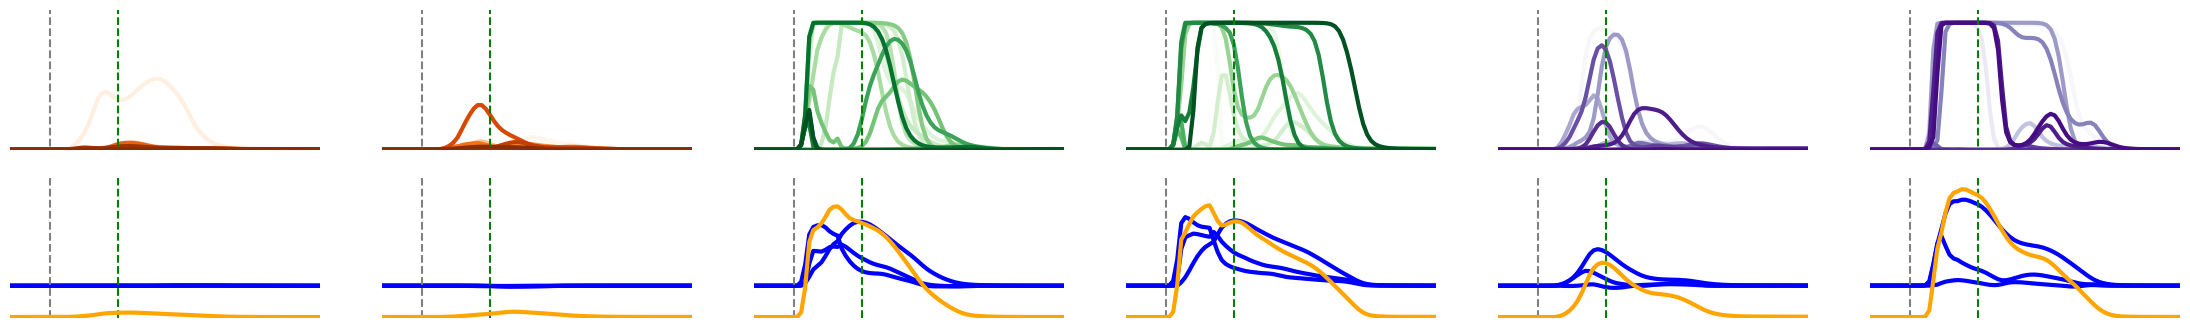

In [102]:
#hereee

time = results_seq['time']
r_ctx = results_seq['rates_ctx']
overlaps = results_seq['overlaps_sym']


ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 28
lw_fr = 3 
lw_ov = 3

dt = modelparams['dt']
t_start = modelparams['t_start']
deltat = modelparams['t_stim'] #time before stimulus
t_stop = t_start + 1
t_end = t_stop


colors_oranges = plt.cm.Oranges(np.linspace(0,1, N_neu))
colors_purples = plt.cm.Purples(np.linspace(0, 1 , N_neu))
colors_greens = plt.cm.Greens(np.linspace(0, 1 , N_neu))

fig, ax = plt.subplots(figsize=(28, 4),nrows=2, ncols=6)

dN = 10
s = 0
#frist column
color_obs = 'green'
x_obs = t_start+0.25
ind1 = names_ctx.index('V1')
for l in range(ind1* N_neu, (ind1+1)* N_neu, dN):
    ax[0,0].plot(time, r_ctx[:, l], color = colors_oranges[l-ind1* N_neu], lw= lw_fr)
ax[0,0].set_ylim([0,1.1])
ax[0,0].set_xticks([])
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['bottom'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].set_xlim([t_start-deltat, t_end])
ax[0,0].set_yticks([])
#ax[0,0].set_yticks([0, 0.5, 1])
#ax[0,0].set_yticklabels([0, 0.5, 1], fontsize = s_ticks)
ax[0,0].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,0].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )


#for k in range(overlaps.shape[3]):
ax[1,0].plot(time, overlaps[:, ind1, s, :], color = 'b', lw= lw_ov)
ax[1,0].set_ylim([-.15,0.5])
ax[1,0].set_xlim([t_end - 2, t_end])
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].spines['bottom'].set_visible(False)
ax[1,0].set_xlim([t_start-deltat, t_end])
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
#ax[1,0].set_xticks([t_start, t_start+0.5, t_start+1])
#ax[1,0].set_xticklabels([ 0,  0.5, 1], fontsize = s_ticks)
#ax[1,0].set_yticks([0, 0.2, 0.4])
#ax[1,0].set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)
ax[1,0].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,0].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )

ax10 = ax[1,0].twinx()
r_mean1 = np.mean(r_ctx[:, ind1* N_neu: (ind1+1)* N_neu], axis = 1)
ax10.plot(time,  r_mean1, color = m_fr_color, lw= lw_ov)
ax10.set_ylim([0,0.5])
ax10.set_xlim([t_start-deltat, t_end])
ax10.set_xticks([t_start, t_start+0.5, t_start+1])
ax10.set_xticklabels([0,  0.5, 1], fontsize = s_ticks)
ax10.spines['right'].set_visible(False)
ax10.spines['top'].set_visible(False)
ax10.spines['bottom'].set_visible(False)
ax10.spines['left'].set_visible(False)
ax10.set_yticks([])
ax10.set_xticks([])

#second column

ind2 = names_ctx.index('V4') 
for l in range(ind2* N_neu, (ind2+1)* N_neu, dN):
    ax[0,1].plot(time, r_ctx[:, l],  color = colors_oranges[l - ind2* N_neu], lw= lw_fr)
ax[0,1].set_ylim([0,1.1])
ax[0,1].set_xticks([])
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].spines['bottom'].set_visible(False)
ax[0,1].set_xlim([t_start-deltat, t_end])
ax[0,1].set_yticks([])
ax[0,1].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,1].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )




ax[1,1].plot(time, overlaps[:, ind2, s, :], color = 'b', lw= lw_ov)
#ax[1,1].plot(time, overlaps[:, ind2, 0], color = ov_color, lw= lw_ov)
ax[1,1].set_ylim([-.15,0.5])
ax[1,1].set_xlim([t_end - 2, t_end])
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].spines['bottom'].set_visible(False)
ax[1,1].set_yticks([])
ax[1,1].set_xlim([t_start-deltat, t_end])
ax[1,1].set_xticks([])
#ax[1,1].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,1].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1,1].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,1].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )



ax11 = ax[1,1].twinx()
r_mean = np.mean(r_ctx[:, ind2 * N_neu: (ind2+1) * N_neu], axis = 1)
ax11.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax11.set_ylim([0,0.5])
ax11.set_xlim([t_start-deltat, t_end])
ax11.set_xticks([])
#ax11.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax11.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax11.spines['top'].set_visible(False)
ax11.spines['left'].set_visible(False)
ax11.spines['right'].set_visible(False)
ax11.spines['bottom'].set_visible(False)
ax11.set_yticks([])

#third column

ind3 =  names_ctx.index('LB')#
for l in range(ind3* N_neu, (ind3+1)* N_neu, dN):
    ax[0,2].plot(time, r_ctx[:, l], color = colors_greens[l-ind3* N_neu], lw=lw_fr)
ax[0,2].set_ylim([0,1.1])
ax[0,2].set_xticks([])
ax[0,2].spines['right'].set_visible(False)
ax[0,2].spines['top'].set_visible(False)
ax[0,2].spines['left'].set_visible(False)
ax[0,2].spines['bottom'].set_visible(False)
ax[0,2].set_yticks([])
ax[0,2].set_xlim([t_start-deltat, t_end])
ax[0,2].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,2].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )

ax[1,2].plot(time, overlaps[:, ind3, s, :], color = 'b', lw= lw_ov)
ax[1,2].set_ylim([-.15,0.5])
ax[1,2].spines['right'].set_visible(False)
ax[1,2].spines['top'].set_visible(False)
ax[1,2].spines['left'].set_visible(False)
ax[1,2].spines['bottom'].set_visible(False)
ax[1,2].set_yticks([])
ax[1,2].set_xlim([t_start-deltat, t_end])
ax[1,2].set_xticks([])
#ax[1,2].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,2].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1,2].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,2].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )

ax12 = ax[1,2].twinx()
r_mean = np.mean(r_ctx[:, ind3* N_neu: (ind3+1)* N_neu], axis = 1)
ax12.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax12.set_ylim([0,.5])
ax12.set_xlim([t_start-deltat, t_end])
ax12.set_xticks([])
#ax12.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax12.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
#ax12.spines['right'].set_visible(False)
ax12.spines['top'].set_visible(False)
ax12.spines['left'].set_visible(False)
ax12.spines['right'].set_visible(False)
ax12.spines['bottom'].set_visible(False)
ax12.set_yticks([])
#ax12.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)


#4th column
ind3 = names_ctx.index('PBr')#
for l in range(ind3* N_neu, (ind3+1)* N_neu, dN):
    ax[0,3].plot(time, r_ctx[:, l], color = colors_greens[l-ind3* N_neu], lw=lw_fr)
ax[0,3].set_ylim([0,1.1])
ax[0,3].set_xticks([])
ax[0,3].spines['right'].set_visible(False)
ax[0,3].spines['top'].set_visible(False)
ax[0,3].spines['left'].set_visible(False)
ax[0,3].spines['bottom'].set_visible(False)
ax[0,3].set_yticks([])
ax[0,3].set_xlim([t_start-deltat, t_end])
ax[0,3].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,3].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )

ax[1,3].plot(time, overlaps[:, ind3, s, :], color = 'b', lw= lw_ov)
#ax[1,3].plot(time, overlaps[:, ind3, 1], color = ov_color, lw= lw_ov)
ax[1,3].set_ylim([-.15,0.5])
ax[1,3].set_xlim([t_start-deltat, t_end])
ax[1,3].set_xticks([])
#ax[1,3].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,3].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1,3].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,3].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )
ax[1,3].spines['right'].set_visible(False)
ax[1,3].spines['top'].set_visible(False)
ax[1,3].spines['left'].set_visible(False)
ax[1,3].spines['bottom'].set_visible(False)
ax[1,3].set_yticks([])


ax13 = ax[1,3].twinx()
r_mean = np.mean(r_ctx[:, ind3* N_neu: (ind3+1)* N_neu], axis = 1)
ax13.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax13.set_ylim([0,.5])
ax13.set_xlim([t_start-deltat, t_end])
ax13.set_xticks([])
#ax13.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax13.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax13.spines['top'].set_visible(False)
ax13.spines['left'].set_visible(False)
ax13.spines['right'].set_visible(False)
ax13.spines['bottom'].set_visible(False)
ax13.set_yticks([])


#5th column

ind3 = names_ctx.index('23')
for l in range(ind3* N_neu, (ind3+1)* N_neu, dN):
    ax[0,4].plot(time, r_ctx[:, l], color = colors_purples[l-ind3* N_neu], lw=lw_fr)
ax[0,4].set_ylim([0,1.1])
ax[0,4].set_xticks([])
ax[0,4].spines['right'].set_visible(False)
ax[0,4].spines['top'].set_visible(False)
ax[0,4].spines['left'].set_visible(False)
ax[0,4].spines['bottom'].set_visible(False)
ax[0,4].set_xlim([t_start-deltat, t_end])
ax[0,4].set_yticks([])
ax[0,4].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,4].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )


ax[1,4].plot(time, overlaps[:, ind3, s, :], color = 'b', lw= lw_ov)
ax[1,4].set_ylim([-.15,0.5])
ax[1,4].set_xlim([t_end - 2, t_end])
ax[1,4].spines['right'].set_visible(False)
ax[1,4].spines['top'].set_visible(False)
ax[1,4].spines['left'].set_visible(False)
ax[1,4].spines['bottom'].set_visible(False)
ax[1,4].set_yticks([])
ax[1,4].set_xlim([t_start-deltat, t_end])
ax[1,4].set_xticks([])
#ax[1,4].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,4].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1,4].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,4].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )


ax14 = ax[1,4].twinx()
r_mean = np.mean(r_ctx[:, ind3* N_neu: (ind3+1)* N_neu], axis = 1)
ax14.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax14.set_ylim([0,.5])
ax14.set_xlim([t_start-deltat, t_end])
ax14.set_xticks([])
#ax14.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax14.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax14.spines['right'].set_visible(False)
ax14.spines['top'].set_visible(False)
ax14.spines['left'].set_visible(False)
ax14.spines['bottom'].set_visible(False)
ax14.set_yticks([])

#6th column
ind6 = names_ctx.index('INS')
for l in range(ind6 * N_neu, (ind6 + 1)* N_neu, dN):
    ax[0,5].plot(time, r_ctx[:, l], color = colors_purples[l-ind6* N_neu], lw=lw_fr)
ax[0,5].set_ylim([0,1.1])
ax[0,5].set_xticks([])
ax[0,5].spines['right'].set_visible(False)
ax[0,5].spines['top'].set_visible(False)
ax[0,5].spines['left'].set_visible(False)
ax[0,5].spines['bottom'].set_visible(False)
ax[0,5].set_xlim([t_start-deltat, t_end])
ax[0,5].set_yticks([])
ax[0,5].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,5].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )

ax[1,5].plot(time, overlaps[:, ind6, s, :], color = 'b', lw= lw_ov)
ax[1,5].set_ylim([-.15,0.5])
ax[1,5].set_xlim([t_end - 2, t_end])
ax[1,5].spines['right'].set_visible(False)
ax[1,5].spines['top'].set_visible(False)
ax[1,5].spines['left'].set_visible(False)
ax[1,5].spines['bottom'].set_visible(False)
ax[1,5].set_yticks([])
ax[1,5].set_xlim([t_start-deltat, t_end])
ax[1,5].set_xticks([])
#ax[1,5].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,5].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1,5].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,5].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )
#ax[1,5].axhline(y=0, xmin=0, xmax=400, ls = '--',color='gray')

ax15 = ax[1,5].twinx()
r_mean = np.mean(r_ctx[:, ind6 * N_neu: (ind6 + 1)* N_neu], axis = 1)
ax15.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax15.set_ylim([0,.5])
ax15.set_xlim([t_start-deltat, t_end])
ax15.set_xticks([])
#ax15.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax15.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
#ax12.spines['right'].set_visible(False)
ax15.spines['top'].set_visible(False)
ax15.spines['left'].set_visible(False)
ax15.spines['bottom'].set_visible(False)
ax15.spines['right'].set_visible(False)
#ax15.set_yticks([0, 0.2, 0.4])
#ax15.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)
ax15.set_yticks([])



plt.savefig('figures/panels/salience_auditory.pdf', bbox_inches='tight')

In [125]:
if True:
    #save as mat file
    overlaps = results_seq['overlaps_sym'][:,:,0,:]
    sio.savemat('results/overlaps_salient_auditory.mat', {'overlaps_salient_auditory':overlaps})
    r_ctx = results_seq['rates_ctx']
    N_block = modelparams['N_block'] # resolution saved nurons 
    N_recorded = modelparams['N_recorded'] # resolution saved nurons 
    N_neu =int( N_block/int(N_block/N_recorded)) #number recorded neurons
    mean_rates = []
    for l in range(89):
        r_mean = np.mean(r_ctx[:, l * N_neu: (l + 1)* N_neu], axis = 1)
        mean_rates.append(r_mean)
    mean_rates = np.array(mean_rates)
    sio.savemat('results/mean_rate_salient_auditory.mat', {'rate_salient_auditory':mean_rates})



In [129]:
s = 0 #aymmetric patterns
network.overlaps.is_sym = False
task.i_pat = np.zeros(task.i_pat.shape)
task.ind_stim=np.array(auditory)
task.pat_input_random()
network.input_ctx = task.input_current

#network.which_tf = 'sig'

#running dynamics
s0_ctx =  0 * np.random.uniform(0,.1, network.mat.shape[0])
amp_in = 0
for l in inds[s]:
    Nl = l * connectivity.N
    Nlp1 = (l + 1) * connectivity.N
    s0_ctx[Nl : Nlp1] = amp_in * connectivity.hebbian_symmetric.patterns_current_asym[l, :, s, 0]
results_seq = network.dynamics(s0_ctx)

Simulation t= 0.0
Simulation t= 0.015
Simulation t= 0.03
Simulation t= 0.045
Simulation t= 0.06
Simulation t= 0.075
Simulation t= 0.09
Simulation t= 0.105
Simulation t= 0.12
Simulation t= 0.135
Simulation t= 0.15
Simulation t= 0.165
Simulation t= 0.18
Simulation t= 0.195
Simulation t= 0.21
Simulation t= 0.225
Simulation t= 0.24
Simulation t= 0.255
Simulation t= 0.27
Simulation t= 0.285
Simulation t= 0.3
Simulation t= 0.315
Simulation t= 0.33
Simulation t= 0.345
Simulation t= 0.36
Simulation t= 0.375
Simulation t= 0.39
Simulation t= 0.405
Simulation t= 0.42
Simulation t= 0.435
Simulation t= 0.45
Simulation t= 0.465
Simulation t= 0.48
Simulation t= 0.495
Simulation t= 0.51
Simulation t= 0.525
Simulation t= 0.54
Simulation t= 0.555
Simulation t= 0.57
Simulation t= 0.585
Simulation t= 0.6
Simulation t= 0.615
Simulation t= 0.63
Simulation t= 0.645
Simulation t= 0.66
Simulation t= 0.675
Simulation t= 0.69
Simulation t= 0.705
Simulation t= 0.72
Simulation t= 0.735
Simulation t= 0.75
Simulatio

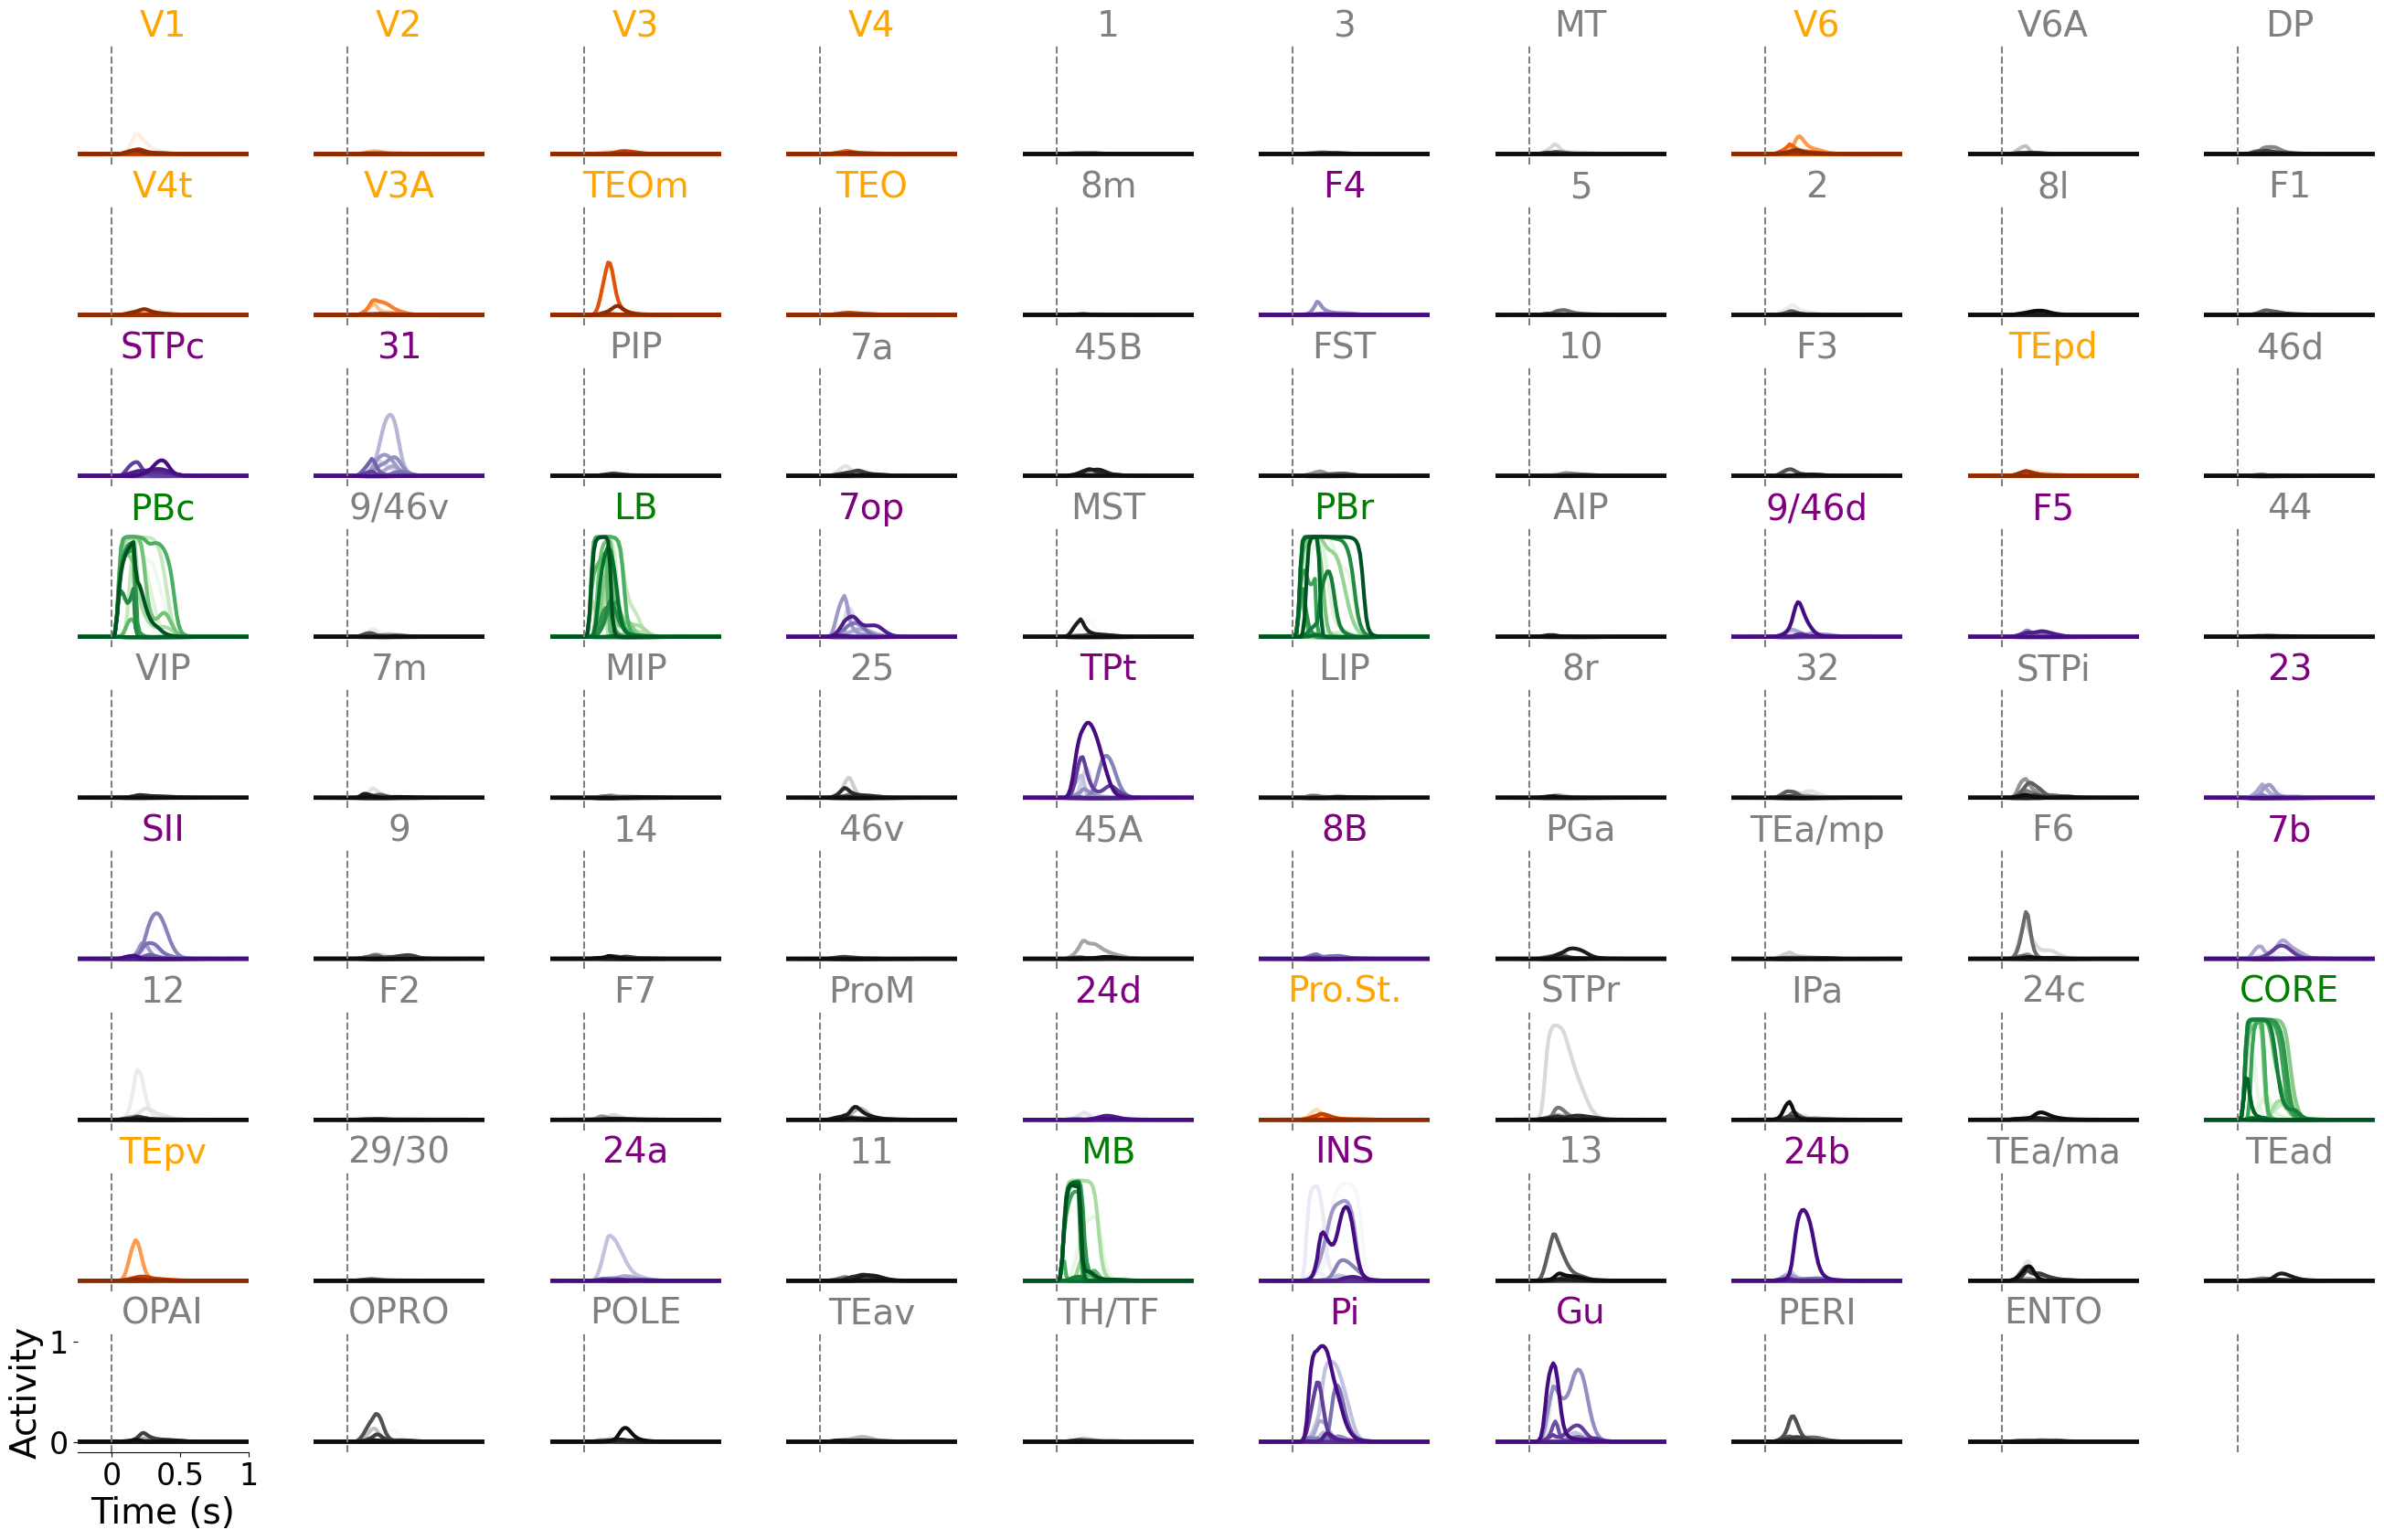

In [130]:
names_ctx = connectivity_params['names_ctx']
#results = pickle.load(open('data/gradient_chaos/sim_0.011.p', 'rb'))
time = results_seq['time']
r_ctx = results_seq['rates_ctx']
name = 'figures/S_random_auditory_rates.pdf'

lw_ov = 2
lw_fr = 3


ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 24

fs=28
N_block = modelparams['N_block'] # resolution saved nurons 
N_recorded = modelparams['N_recorded'] # resolution saved nurons 
N_neu =int( N_block/int(N_block/N_recorded)) #number recorded neurons
colors = plt.cm.hsv(np.linspace(0,1, N_neu))
names_ctx, inds_full = names_inds_ctx()
dt = modelparams['dt']
t_start = modelparams['t_start']
t_stop = t_start + 1
t_end = t_stop



colors_oranges = plt.cm.Oranges(np.linspace(0,1, N_neu))
colors_greens = plt.cm.Greens(np.linspace(0,1, N_neu))
colors_greys = plt.cm.Greys(np.linspace(0, 1 , N_neu))
colors_purples = plt.cm.Purples(np.linspace(0, 1 , N_neu))

# plotting altoghether 
fig, ax = plt.subplots(figsize=(26, 16),nrows=9, ncols=10)
fig.tight_layout()
l=0
n_row= 0
for row in ax:
    n_col=0
    for col in row:
        if l<=88:
            ind_1 = l * N_neu
            ind_2 = (l+1) * N_neu
            #col.set_prop_cycle(cycler('color', colors))
            if l in subnetworks['Visual']:
                color = 'orange'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_oranges[k - l* N_neu])
            elif l in subnetworks['Salience']:
                color = 'purple'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_purples[k - l* N_neu])
            elif l in auditory:
                color = 'green'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_greens[k - l* N_neu])
            else:
                color = 'grey'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_greys[k - l* N_neu])
            col.set_title(names_ctx[l],fontsize = fs, color = color)
        col.set_ylim([-.1,1.1])
        col.set_xlim([t_start-.25, t_end])
        col.axvline(x=t_start, ymin=0, ymax=200, ls = '--',color='gray')
        if n_col!=0:
            col.set_yticks([])
            col.set_xticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
        if n_row!=8:
            col.set_xticks([])
            col.set_yticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
        if n_col==0 and n_row==8:
            col.set_ylabel('Activity', fontsize =fs)
            col.set_yticks([0, 1])
            col.set_yticklabels([0, 1], fontsize = s_ticks)
            col.set_xlabel('Time (s)', fontsize = fs)
            col.set_xticks([ t_start, t_start+0.5, t_start+1])
            col.set_xticklabels([0,  0.5, 1], fontsize = s_ticks)
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)

        l+=1
        n_col+=1
    n_row+=1
    #plt.savefig(name, bbox_inches='tight')
plt.savefig(name, bbox_inches='tight')

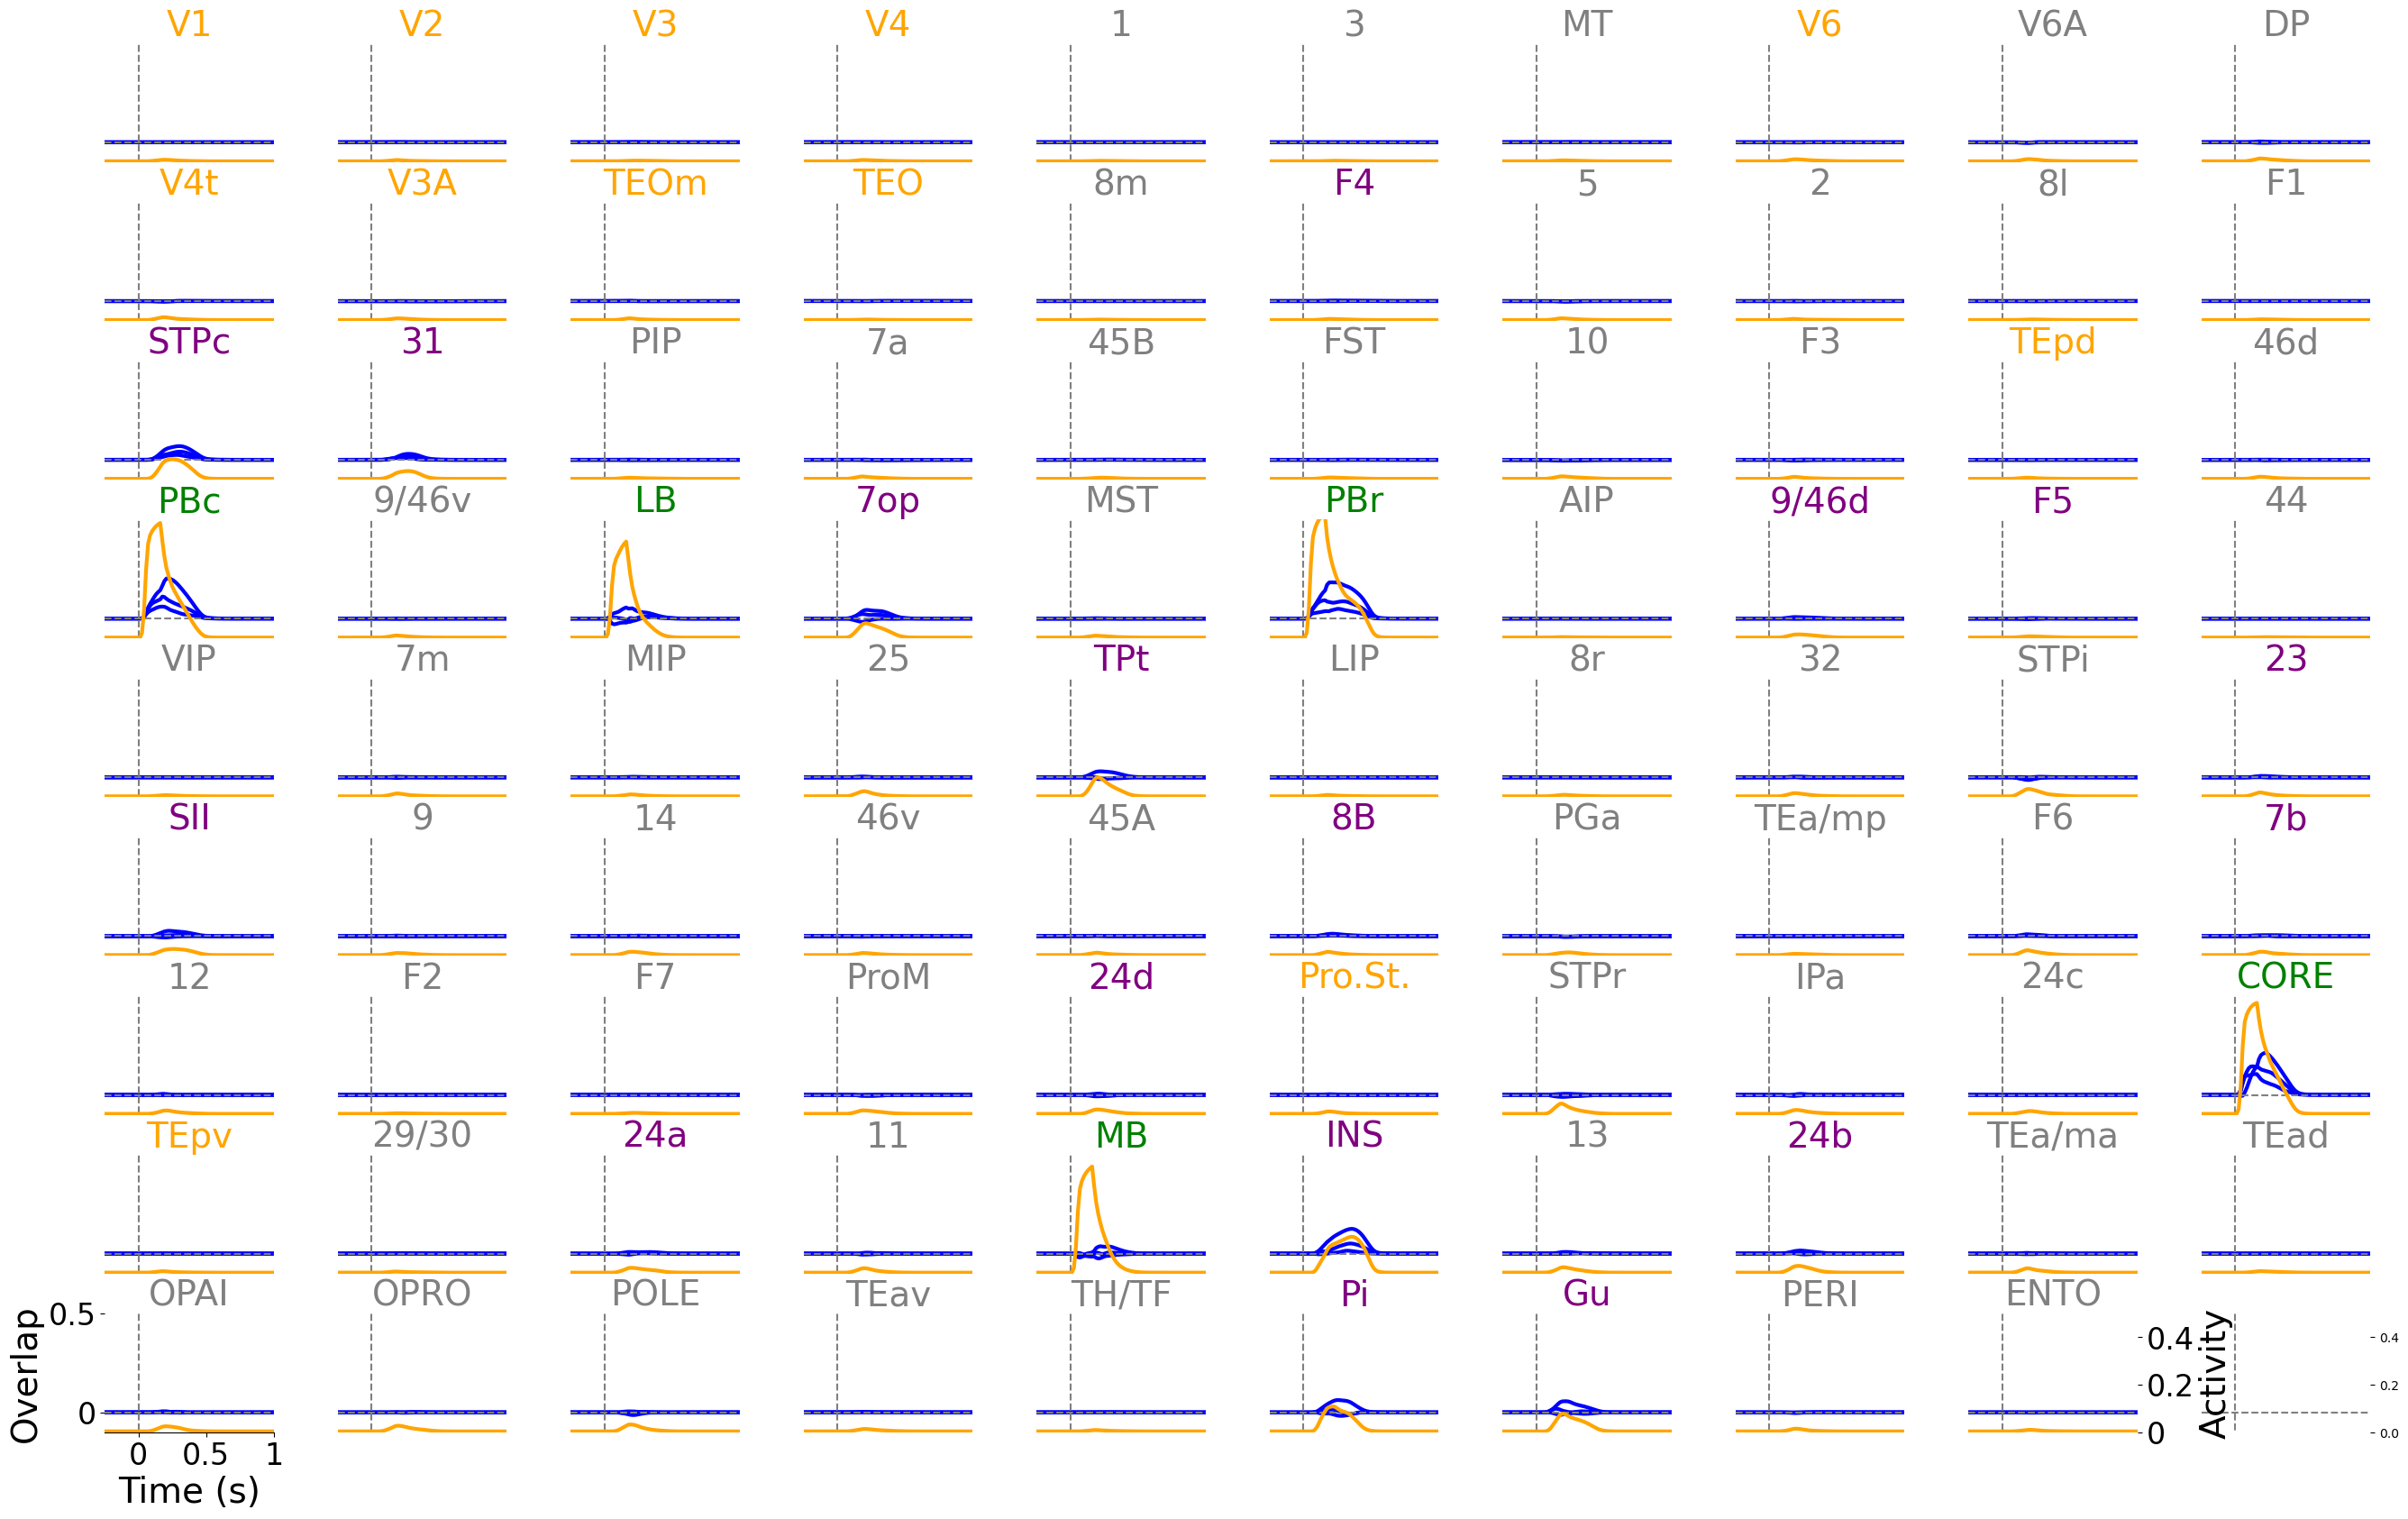

In [131]:
names_ctx = connectivity_params['names_ctx']
time = results_seq['time']
r_ctx = results_seq['rates_ctx']
overlaps = results_seq['overlaps_sym']


name_grad = 'figures/S_random_auditory_overlaps.pdf'

lw_ov = 3
lw_fr = 3


ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 24
colors_overlaps = plt.cm.Dark2(np.linspace(0,1, 8))

fs=28

N_block = modelparams['N_block']
p = overlaps.shape[2]
colors = plt.cm.hsv(np.linspace(0,1,N_block))
names_ctx, inds_full = names_inds_ctx()
dt = modelparams['dt']
t_start = modelparams['t_start']

t_stop = t_start + 1
t_end = t_stop

colors = ['b', 'r']
fig, ax = plt.subplots(figsize=(26, 16),nrows=9, ncols=10)
fig.tight_layout()
l=0
n_row= 0
for row in ax:
    n_col=0
    for col in row:
        if l<89:
            #for s in range(p):
            if l in subnetworks['Salience']:
                color = 'purple'
            elif l in subnetworks['Visual']:
                color = 'orange'
            elif l in auditory:
                color = 'green'
            else:
                color = 'grey'
            col.plot(time, overlaps[:, l, 0, :], lw =lw_ov, color = 'b')
            col.set_title(names_ctx[l],fontsize = fs, color = color)
            axij = col.twinx()
            r_mean = np.mean(r_ctx[:, l * N_neu: (l + 1)* N_neu], axis = 1)
            axij.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
            axij.set_ylim([0,.5])
        col.set_ylim([-.1,0.5])
        col.set_xlim([t_start-0.25, t_end])
        col.axhline(y=0, xmin=0, xmax=400, ls = '--',color='gray')
        col.axvline(x=t_start, ymin=-2, ymax=2, ls = '--',color='gray')
        if n_col!=0:
            col.set_yticks([])
            col.set_xticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
            axij.spines['right'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['bottom'].set_visible(False)
            axij.set_yticks([])
            axij.set_xticks([])
        if n_row!=8:
            col.set_xticks([])
            col.set_yticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
        if n_row==8 and n_col==0:
            col.set_ylabel('Overlap', fontsize =fs)
            col.set_yticks([0, 0.5])
            col.set_yticklabels([0, 0.5], fontsize = s_ticks)
        
            col.set_xlabel('Time (s)', fontsize = fs)
            col.set_xticks([t_start, t_start+0.5, t_start+1])
            col.set_xticklabels([0, 0.5,1], fontsize = s_ticks)
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
        if n_col != 9:
            axij.spines['right'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['bottom'].set_visible(False)
            axij.set_yticks([])
        if n_col==9 and n_row==8:
            axij.set_yticks([0, 0.2, 0.4])
            axij.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)
            axij.spines['bottom'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['right'].set_visible(False)
            axij.set_ylabel('Activity', fontsize =fs)
        
            col.plot(time, -20 * time -1, lw =lw_ov, color = 'blue')
            axij = col.twinx()
            axij.plot(time,  -20 * time - 1, color = m_fr_color, lw= lw_ov)
            col.set_ylim([-.1,0.5])
            axij.set_ylim([0,.5])
            axij.spines['right'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['bottom'].set_visible(False)
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
            col.set_xticks([])
            col.set_yticks([])
            col.set_xlabel('', fontsize = fs)
 
            
        l+=1
        n_col+=1
    n_row+=1
#plt.savefig(str_ov, bbox_inches='tight')
#plt.close()
plt.savefig(name_grad, bbox_inches='tight')

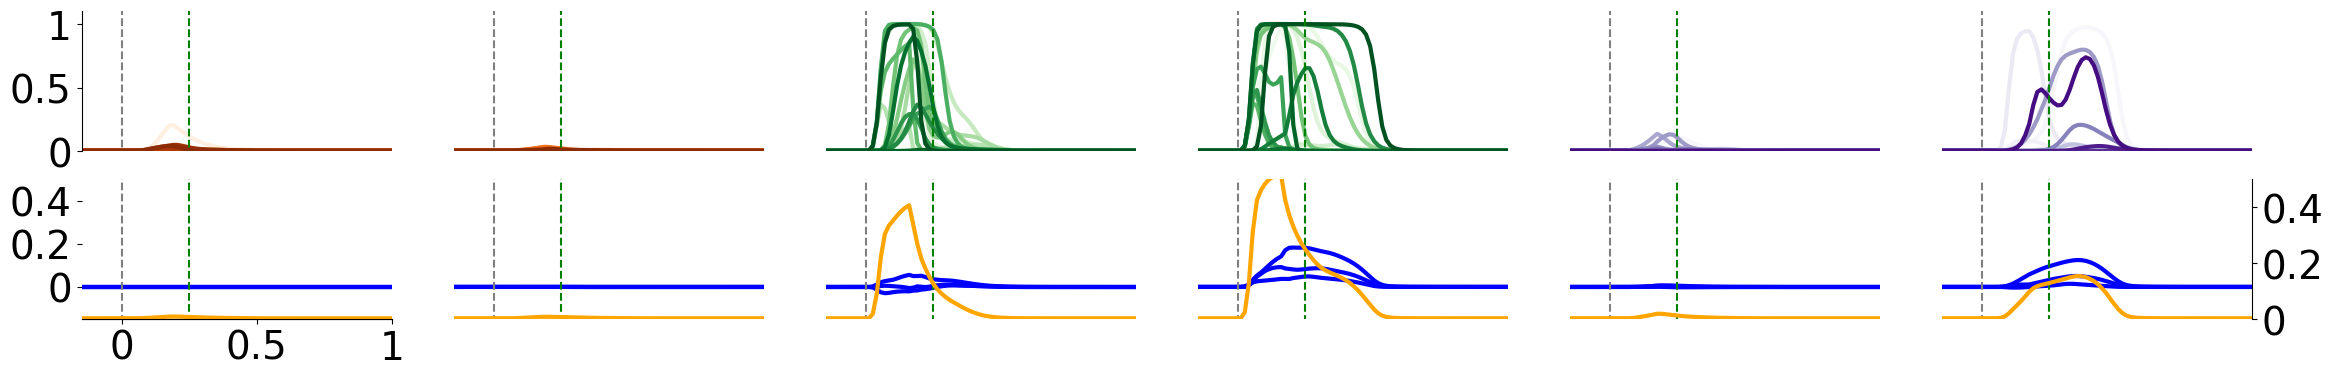

In [133]:
#hereee

time = results_seq['time']
r_ctx = results_seq['rates_ctx']
overlaps = results_seq['overlaps_sym']


ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 28
lw_fr = 3 
lw_ov = 3

#hereee

time = results_seq['time']
r_ctx = results_seq['rates_ctx']
overlaps = results_seq['overlaps_sym']


ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 28
lw_fr = 3 
lw_ov = 3

dt = modelparams['dt']
t_start = modelparams['t_start']
deltat = modelparams['t_stim'] #time before stimulus
t_stop = t_start + 1
t_end = t_stop


colors_oranges = plt.cm.Oranges(np.linspace(0,1, N_neu))
colors_purples = plt.cm.Purples(np.linspace(0, 1 , N_neu))
colors_greens = plt.cm.Greens(np.linspace(0, 1 , N_neu))

fig, ax = plt.subplots(figsize=(28, 4),nrows=2, ncols=6)

dN = 10
s = 0
#frist column
color_obs = 'green'
x_obs = t_start+0.25
ind1 = names_ctx.index('V1')
for l in range(ind1* N_neu, (ind1+1)* N_neu, dN):
    ax[0,0].plot(time, r_ctx[:, l], color = colors_oranges[l-ind1* N_neu], lw= lw_fr)
ax[0,0].set_ylim([0,1.1])
ax[0,0].set_xticks([])
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['bottom'].set_visible(False)
#ax[0,0].spines['left'].set_visible(False)
ax[0,0].set_xlim([t_start-deltat, t_end])
#ax[0,0].set_yticks([])
ax[0,0].set_yticks([0, 0.5, 1])
ax[0,0].set_yticklabels([0, 0.5, 1], fontsize = s_ticks)
ax[0,0].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,0].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )


#for k in range(overlaps.shape[3]):
ax[1,0].plot(time, overlaps[:, ind1, s, :], color = 'b', lw= lw_ov)
ax[1,0].set_ylim([-.15,0.5])
ax[1,0].set_xlim([t_end - 2, t_end])
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
#ax[1,0].spines['bottom'].set_visible(False)
ax[1,0].set_xlim([t_start-deltat, t_end])
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,0].set_xticks([t_start, t_start+0.5, t_start+1])
ax[1,0].set_xticklabels([ 0,  0.5, 1], fontsize = s_ticks)
ax[1,0].set_yticks([0, 0.2, 0.4])
ax[1,0].set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)
ax[1,0].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,0].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )

ax10 = ax[1,0].twinx()
r_mean1 = np.mean(r_ctx[:, ind1* N_neu: (ind1+1)* N_neu], axis = 1)
ax10.plot(time,  r_mean1, color = m_fr_color, lw= lw_ov)
ax10.set_ylim([0,0.5])
ax10.set_xlim([t_start-deltat, t_end])
ax10.set_xticks([t_start, t_start+0.5, t_start+1])
ax10.set_xticklabels([0,  0.5, 1], fontsize = s_ticks)
ax10.spines['right'].set_visible(False)
ax10.spines['top'].set_visible(False)
#ax10.spines['bottom'].set_visible(False)
ax10.spines['left'].set_visible(False)
ax10.set_yticks([])
#ax10.set_xticks([])

#second column

ind2 = names_ctx.index('V4') 
for l in range(ind2* N_neu, (ind2+1)* N_neu, dN):
    ax[0,1].plot(time, r_ctx[:, l],  color = colors_oranges[l - ind2* N_neu], lw= lw_fr)
ax[0,1].set_ylim([0,1.1])
ax[0,1].set_xticks([])
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].spines['bottom'].set_visible(False)
ax[0,1].set_xlim([t_start-deltat, t_end])
ax[0,1].set_yticks([])
ax[0,1].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,1].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )




ax[1,1].plot(time, overlaps[:, ind2, s, :], color = 'b', lw= lw_ov)
#ax[1,1].plot(time, overlaps[:, ind2, 0], color = ov_color, lw= lw_ov)
ax[1,1].set_ylim([-.15,0.5])
ax[1,1].set_xlim([t_end - 2, t_end])
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].spines['bottom'].set_visible(False)
ax[1,1].set_yticks([])
ax[1,1].set_xlim([t_start-deltat, t_end])
ax[1,1].set_xticks([])
#ax[1,1].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,1].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1,1].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,1].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )



ax11 = ax[1,1].twinx()
r_mean = np.mean(r_ctx[:, ind2 * N_neu: (ind2+1) * N_neu], axis = 1)
ax11.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax11.set_ylim([0,0.5])
ax11.set_xlim([t_start-deltat, t_end])
ax11.set_xticks([])
#ax11.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax11.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax11.spines['top'].set_visible(False)
ax11.spines['left'].set_visible(False)
ax11.spines['right'].set_visible(False)
ax11.spines['bottom'].set_visible(False)
ax11.set_yticks([])

#third column

ind3 =  names_ctx.index('LB')#
for l in range(ind3* N_neu, (ind3+1)* N_neu, dN):
    ax[0,2].plot(time, r_ctx[:, l], color = colors_greens[l-ind3* N_neu], lw=lw_fr)
ax[0,2].set_ylim([0,1.1])
ax[0,2].set_xticks([])
ax[0,2].spines['right'].set_visible(False)
ax[0,2].spines['top'].set_visible(False)
ax[0,2].spines['left'].set_visible(False)
ax[0,2].spines['bottom'].set_visible(False)
ax[0,2].set_yticks([])
ax[0,2].set_xlim([t_start-deltat, t_end])
ax[0,2].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,2].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )

ax[1,2].plot(time, overlaps[:, ind3, s, :], color = 'b', lw= lw_ov)
ax[1,2].set_ylim([-.15,0.5])
ax[1,2].spines['right'].set_visible(False)
ax[1,2].spines['top'].set_visible(False)
ax[1,2].spines['left'].set_visible(False)
ax[1,2].spines['bottom'].set_visible(False)
ax[1,2].set_yticks([])
ax[1,2].set_xlim([t_start-deltat, t_end])
ax[1,2].set_xticks([])
#ax[1,2].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,2].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1,2].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,2].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )

ax12 = ax[1,2].twinx()
r_mean = np.mean(r_ctx[:, ind3* N_neu: (ind3+1)* N_neu], axis = 1)
ax12.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax12.set_ylim([0,.5])
ax12.set_xlim([t_start-deltat, t_end])
ax12.set_xticks([])
#ax12.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax12.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
#ax12.spines['right'].set_visible(False)
ax12.spines['top'].set_visible(False)
ax12.spines['left'].set_visible(False)
ax12.spines['right'].set_visible(False)
ax12.spines['bottom'].set_visible(False)
ax12.set_yticks([])
#ax12.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)


#4th column
ind3 = names_ctx.index('PBr')#
for l in range(ind3* N_neu, (ind3+1)* N_neu, dN):
    ax[0,3].plot(time, r_ctx[:, l], color = colors_greens[l-ind3* N_neu], lw=lw_fr)
ax[0,3].set_ylim([0,1.1])
ax[0,3].set_xticks([])
ax[0,3].spines['right'].set_visible(False)
ax[0,3].spines['top'].set_visible(False)
ax[0,3].spines['left'].set_visible(False)
ax[0,3].spines['bottom'].set_visible(False)
ax[0,3].set_yticks([])
ax[0,3].set_xlim([t_start-deltat, t_end])
ax[0,3].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,3].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )

ax[1,3].plot(time, overlaps[:, ind3, s, :], color = 'b', lw= lw_ov)
#ax[1,3].plot(time, overlaps[:, ind3, 1], color = ov_color, lw= lw_ov)
ax[1,3].set_ylim([-.15,0.5])
ax[1,3].set_xlim([t_start-deltat, t_end])
ax[1,3].set_xticks([])
#ax[1,3].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,3].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1,3].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,3].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )
ax[1,3].spines['right'].set_visible(False)
ax[1,3].spines['top'].set_visible(False)
ax[1,3].spines['left'].set_visible(False)
ax[1,3].spines['bottom'].set_visible(False)
ax[1,3].set_yticks([])


ax13 = ax[1,3].twinx()
r_mean = np.mean(r_ctx[:, ind3* N_neu: (ind3+1)* N_neu], axis = 1)
ax13.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax13.set_ylim([0,.5])
ax13.set_xlim([t_start-deltat, t_end])
ax13.set_xticks([])
#ax13.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax13.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax13.spines['top'].set_visible(False)
ax13.spines['left'].set_visible(False)
ax13.spines['right'].set_visible(False)
ax13.spines['bottom'].set_visible(False)
ax13.set_yticks([])


#5th column

ind3 = names_ctx.index('23')
for l in range(ind3* N_neu, (ind3+1)* N_neu, dN):
    ax[0,4].plot(time, r_ctx[:, l], color = colors_purples[l-ind3* N_neu], lw=lw_fr)
ax[0,4].set_ylim([0,1.1])
ax[0,4].set_xticks([])
ax[0,4].spines['right'].set_visible(False)
ax[0,4].spines['top'].set_visible(False)
ax[0,4].spines['left'].set_visible(False)
ax[0,4].spines['bottom'].set_visible(False)
ax[0,4].set_xlim([t_start-deltat, t_end])
ax[0,4].set_yticks([])
ax[0,4].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,4].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )


ax[1,4].plot(time, overlaps[:, ind3, s, :], color = 'b', lw= lw_ov)
ax[1,4].set_ylim([-.15,0.5])
ax[1,4].set_xlim([t_end - 2, t_end])
ax[1,4].spines['right'].set_visible(False)
ax[1,4].spines['top'].set_visible(False)
ax[1,4].spines['left'].set_visible(False)
ax[1,4].spines['bottom'].set_visible(False)
ax[1,4].set_yticks([])
ax[1,4].set_xlim([t_start-deltat, t_end])
ax[1,4].set_xticks([])
#ax[1,4].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,4].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1,4].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,4].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )


ax14 = ax[1,4].twinx()
r_mean = np.mean(r_ctx[:, ind3* N_neu: (ind3+1)* N_neu], axis = 1)
ax14.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax14.set_ylim([0,.5])
ax14.set_xlim([t_start-deltat, t_end])
ax14.set_xticks([])
#ax14.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax14.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax14.spines['right'].set_visible(False)
ax14.spines['top'].set_visible(False)
ax14.spines['left'].set_visible(False)
ax14.spines['bottom'].set_visible(False)
ax14.set_yticks([])

#6th column
ind6 = names_ctx.index('INS')
for l in range(ind6 * N_neu, (ind6 + 1)* N_neu, dN):
    ax[0,5].plot(time, r_ctx[:, l], color = colors_purples[l-ind6* N_neu], lw=lw_fr)
ax[0,5].set_ylim([0,1.1])
ax[0,5].set_xticks([])
ax[0,5].spines['right'].set_visible(False)
ax[0,5].spines['top'].set_visible(False)
ax[0,5].spines['left'].set_visible(False)
ax[0,5].spines['bottom'].set_visible(False)
ax[0,5].set_xlim([t_start-deltat, t_end])
ax[0,5].set_yticks([])
ax[0,5].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,5].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )

ax[1,5].plot(time, overlaps[:, ind6, s, :], color = 'b', lw= lw_ov)
ax[1,5].set_ylim([-.15,0.5])
ax[1,5].set_xlim([t_end - 2, t_end])
ax[1,5].spines['right'].set_visible(False)
ax[1,5].spines['top'].set_visible(False)
ax[1,5].spines['left'].set_visible(False)
ax[1,5].spines['bottom'].set_visible(False)
ax[1,5].set_yticks([])
ax[1,5].set_xlim([t_start-deltat, t_end])
ax[1,5].set_xticks([])
#ax[1,5].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,5].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1,5].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,5].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )
#ax[1,5].axhline(y=0, xmin=0, xmax=400, ls = '--',color='gray')

ax15 = ax[1,5].twinx()
r_mean = np.mean(r_ctx[:, ind6 * N_neu: (ind6 + 1)* N_neu], axis = 1)
ax15.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax15.set_ylim([0,.5])
ax15.set_xlim([t_start-deltat, t_end])
ax15.set_xticks([])
#ax15.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax15.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
#ax12.spines['right'].set_visible(False)
ax15.spines['top'].set_visible(False)
ax15.spines['left'].set_visible(False)
ax15.spines['bottom'].set_visible(False)
#ax15.spines['right'].set_visible(False)
ax15.set_yticks([0, 0.2, 0.4])
ax15.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)
#ax15.set_yticks([])




plt.savefig('figures/panels/salience_random_auditory.pdf', bbox_inches='tight')

In [115]:
s = 0 #aymmetric patterns
network.overlaps.is_sym = False
task.i_pat = np.zeros(task.i_pat.shape)
task.ind_stim=np.array(subnetworks['Visual'])
task.pat_input_random()
network.input_ctx = task.input_current

#network.which_tf = 'sig'

#running dynamics
s0_ctx =  0 * np.random.uniform(0,.1, network.mat.shape[0])
amp_in = 0
for l in inds[s]:
    Nl = l * connectivity.N
    Nlp1 = (l + 1) * connectivity.N
    s0_ctx[Nl : Nlp1] = amp_in * connectivity.hebbian_symmetric.patterns_current_asym[l, :, s, 0]
results_seq = network.dynamics(s0_ctx)

Simulation t= 0.0
Simulation t= 0.015
Simulation t= 0.03
Simulation t= 0.045
Simulation t= 0.06
Simulation t= 0.075
Simulation t= 0.09
Simulation t= 0.105
Simulation t= 0.12
Simulation t= 0.135
Simulation t= 0.15
Simulation t= 0.165
Simulation t= 0.18
Simulation t= 0.195
Simulation t= 0.21
Simulation t= 0.225
Simulation t= 0.24
Simulation t= 0.255
Simulation t= 0.27
Simulation t= 0.285
Simulation t= 0.3
Simulation t= 0.315
Simulation t= 0.33
Simulation t= 0.345
Simulation t= 0.36
Simulation t= 0.375
Simulation t= 0.39
Simulation t= 0.405
Simulation t= 0.42
Simulation t= 0.435
Simulation t= 0.45
Simulation t= 0.465
Simulation t= 0.48
Simulation t= 0.495
Simulation t= 0.51
Simulation t= 0.525
Simulation t= 0.54
Simulation t= 0.555
Simulation t= 0.57
Simulation t= 0.585
Simulation t= 0.6
Simulation t= 0.615
Simulation t= 0.63
Simulation t= 0.645
Simulation t= 0.66
Simulation t= 0.675
Simulation t= 0.69
Simulation t= 0.705
Simulation t= 0.72
Simulation t= 0.735
Simulation t= 0.75
Simulatio

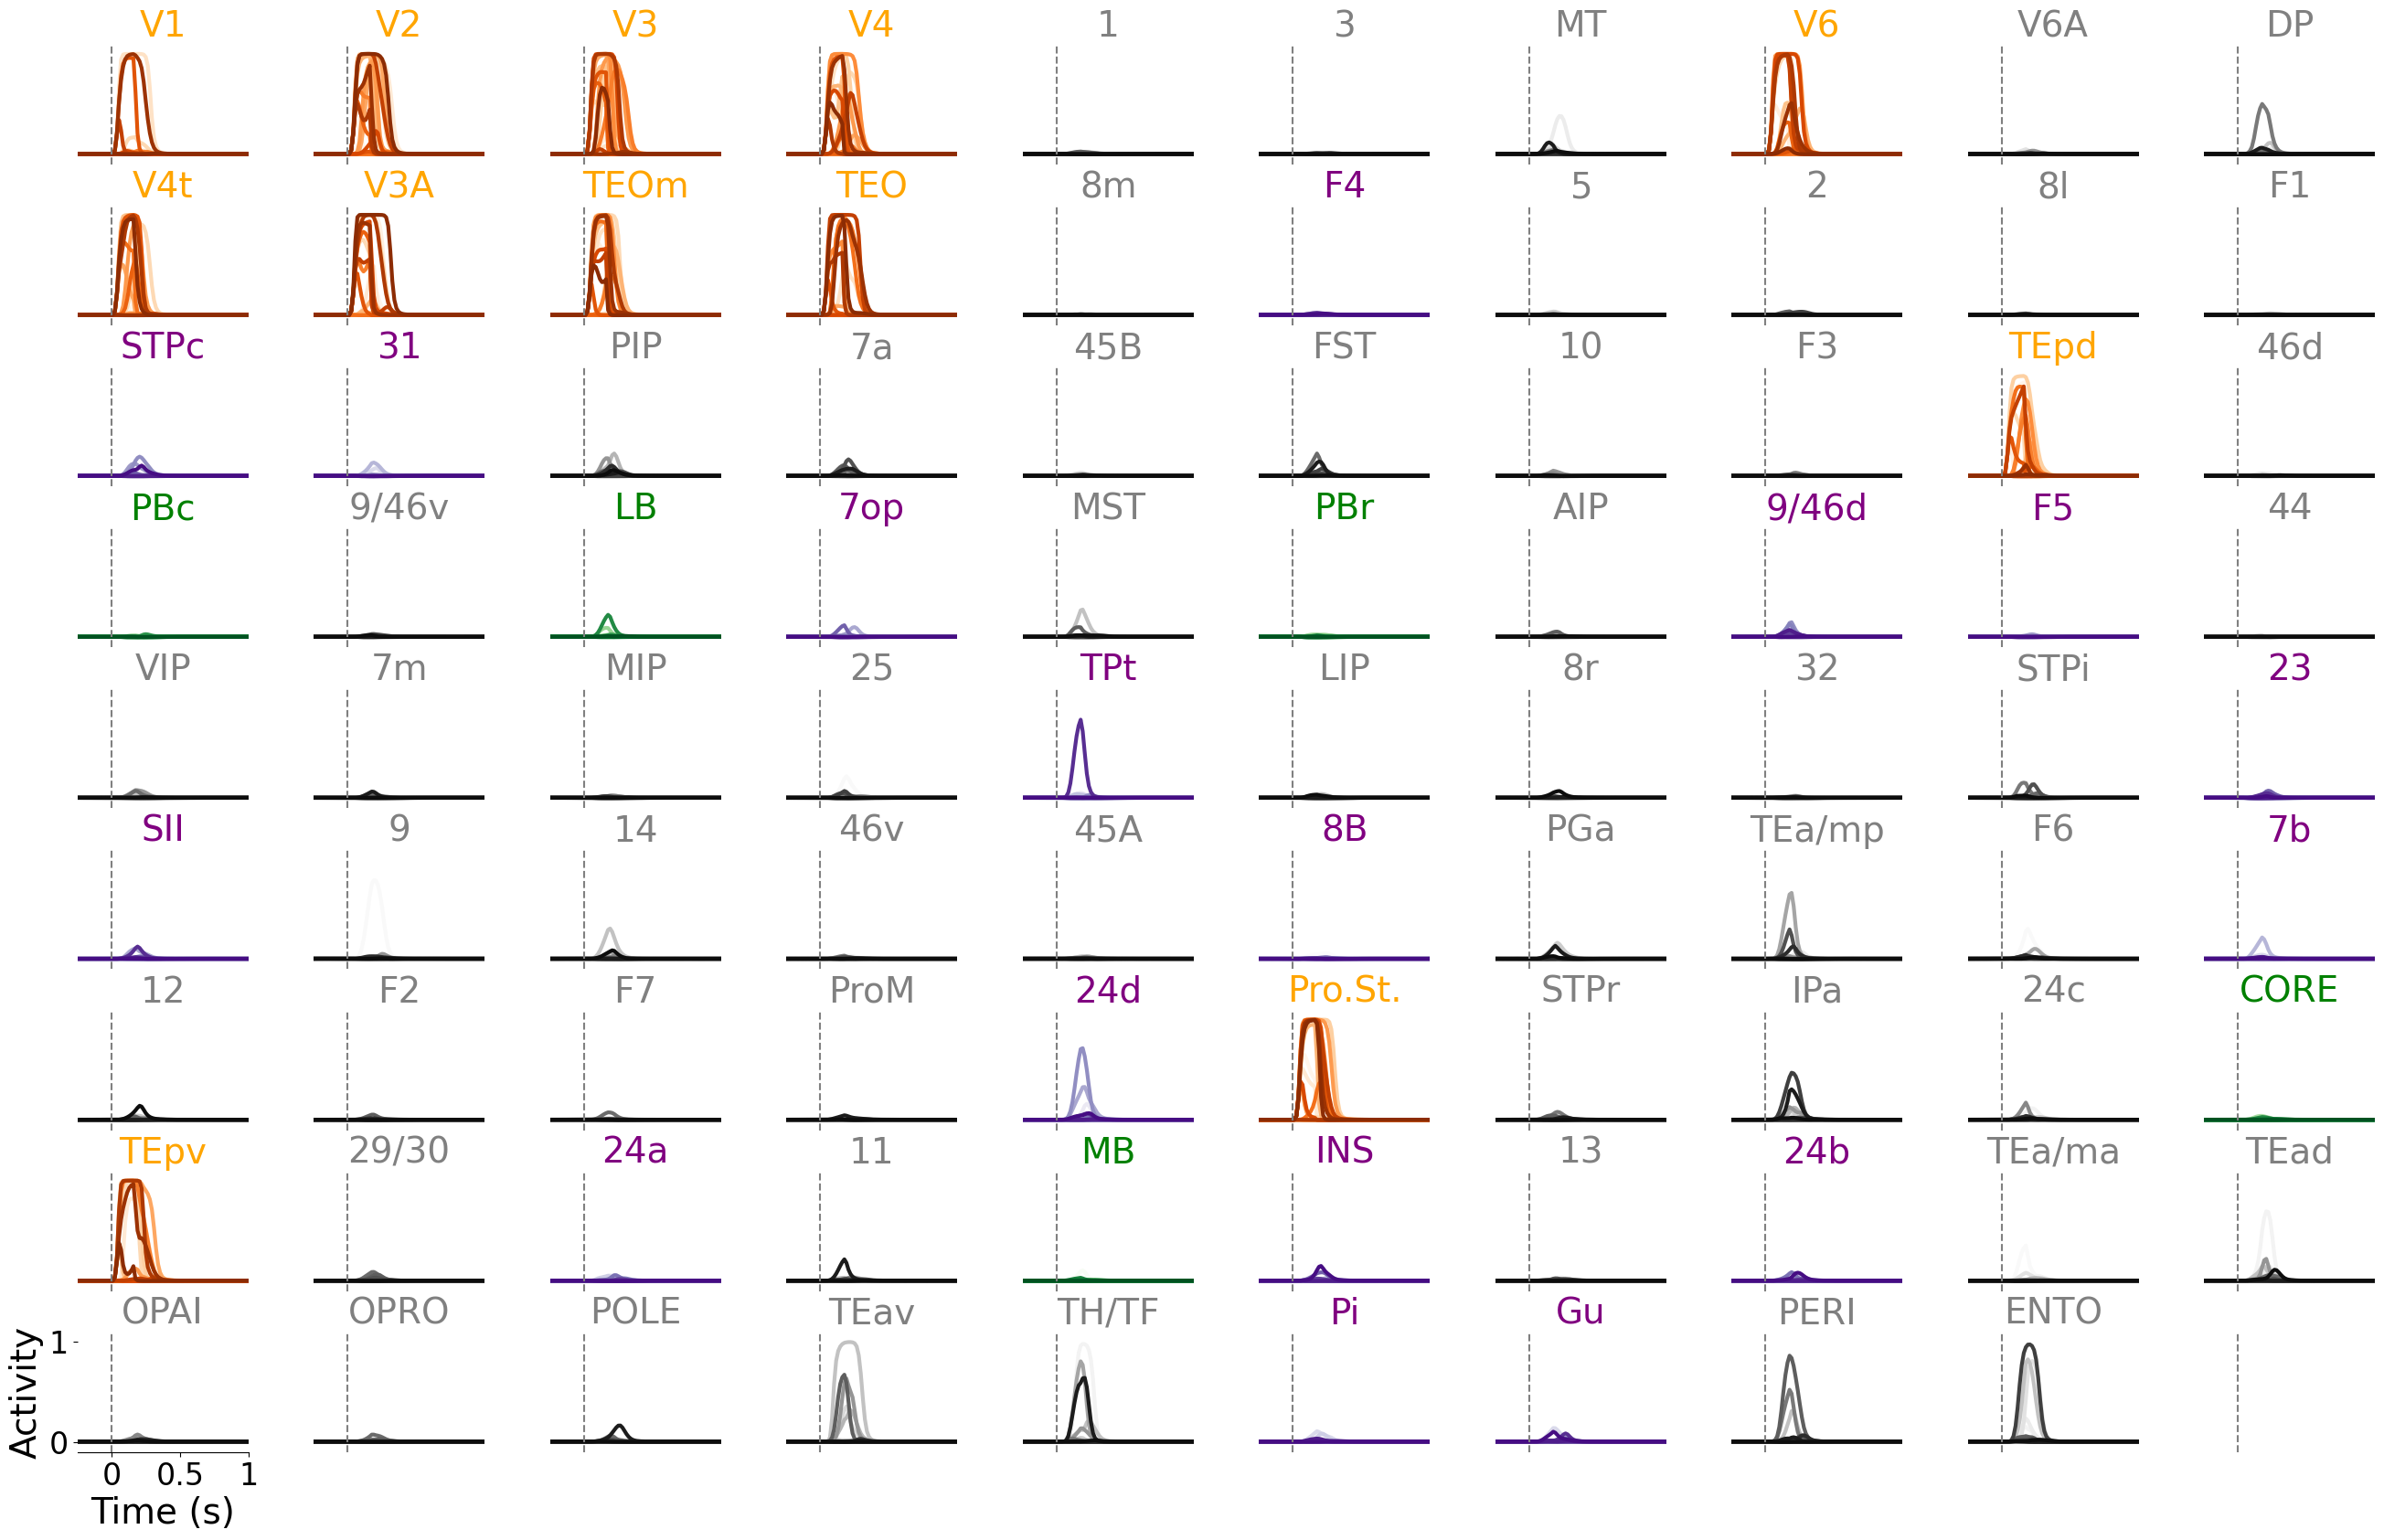

In [124]:
names_ctx = connectivity_params['names_ctx']
#results = pickle.load(open('data/gradient_chaos/sim_0.011.p', 'rb'))
time = results_seq['time']
r_ctx = results_seq['rates_ctx']
name = 'figures/S_random_visual_rates.pdf'

lw_ov = 2
lw_fr = 3


ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 24

fs=28
N_block = modelparams['N_block'] # resolution saved nurons 
N_recorded = modelparams['N_recorded'] # resolution saved nurons 
N_neu =int( N_block/int(N_block/N_recorded)) #number recorded neurons
colors = plt.cm.hsv(np.linspace(0,1, N_neu))
names_ctx, inds_full = names_inds_ctx()
dt = modelparams['dt']
t_start = modelparams['t_start']
dt = modelparams['dt']
t_stop = t_start + 1
t_end = t_stop


colors_oranges = plt.cm.Oranges(np.linspace(0,1, N_neu))
colors_greens = plt.cm.Greens(np.linspace(0,1, N_neu))
colors_greys = plt.cm.Greys(np.linspace(0, 1 , N_neu))
colors_purples = plt.cm.Purples(np.linspace(0, 1 , N_neu))

# plotting altoghether 
fig, ax = plt.subplots(figsize=(26, 16),nrows=9, ncols=10)
fig.tight_layout()
l=0
n_row= 0
for row in ax:
    n_col=0
    for col in row:
        if l<=88:
            ind_1 = l * N_neu
            ind_2 = (l+1) * N_neu
            #col.set_prop_cycle(cycler('color', colors))
            if l in subnetworks['Visual']:
                color = 'orange'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_oranges[k - l* N_neu])
            elif l in subnetworks['Salience']:
                color = 'purple'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_purples[k - l* N_neu])
            elif l in auditory:
                color = 'green'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_greens[k - l* N_neu])
            else:
                color = 'grey'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_greys[k - l* N_neu])
            col.set_title(names_ctx[l],fontsize = fs, color = color)
        col.set_ylim([-.1,1.1])
        col.set_xlim([t_start-.25, t_end])
        col.axvline(x=t_start, ymin=0, ymax=200, ls = '--',color='gray')
        if n_col!=0:
            col.set_yticks([])
            col.set_xticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
        if n_row!=8:
            col.set_xticks([])
            col.set_yticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
        if n_col==0 and n_row==8:
            col.set_ylabel('Activity', fontsize =fs)
            col.set_yticks([0, 1])
            col.set_yticklabels([0, 1], fontsize = s_ticks)
            col.set_xlabel('Time (s)', fontsize = fs)
            col.set_xticks([ t_start, t_start+0.5, t_start+1])
            col.set_xticklabels([0,  0.5, 1], fontsize = s_ticks)
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)

        l+=1
        n_col+=1
    n_row+=1
    #plt.savefig(name, bbox_inches='tight')
plt.savefig(name, bbox_inches='tight')

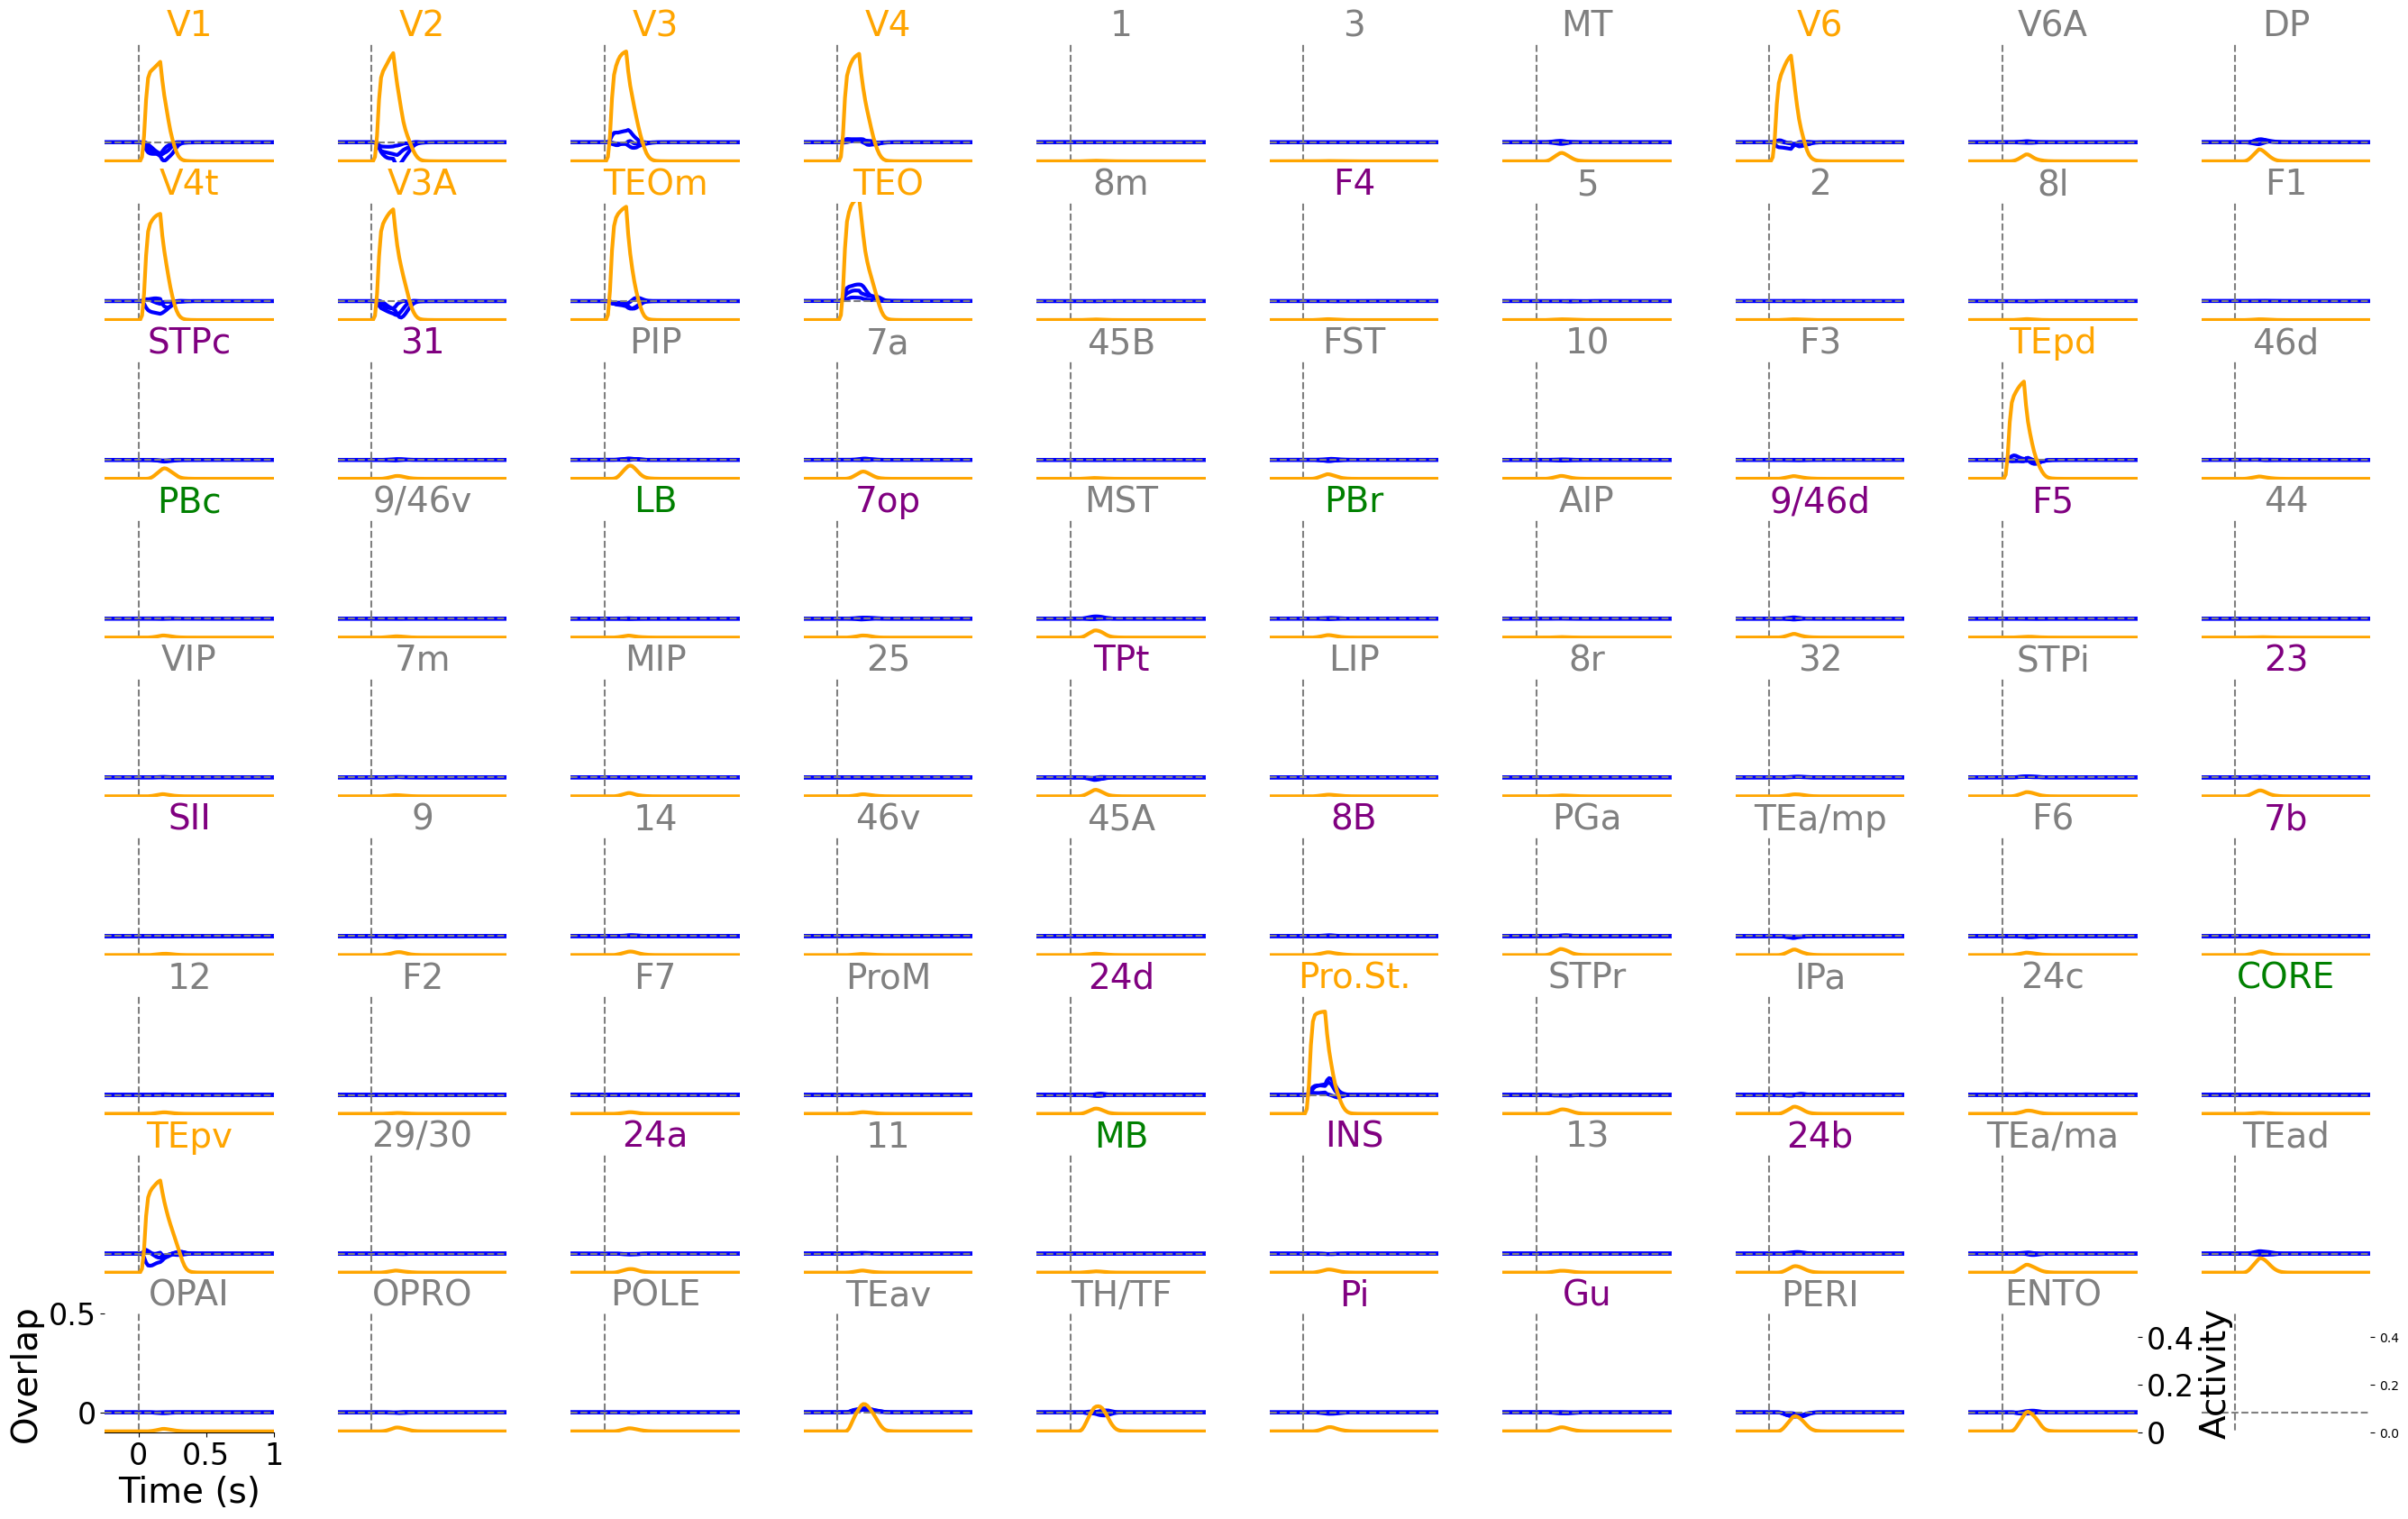

In [123]:
names_ctx = connectivity_params['names_ctx']
time = results_seq['time']
r_ctx = results_seq['rates_ctx']
overlaps = results_seq['overlaps_sym']


name_grad = 'figures/S_random_visual_overlaps.pdf'

lw_ov = 3
lw_fr = 3


ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 24
colors_overlaps = plt.cm.Dark2(np.linspace(0,1, 8))

fs=28

N_block = modelparams['N_block']
p = overlaps.shape[2]
colors = plt.cm.hsv(np.linspace(0,1,N_block))
names_ctx, inds_full = names_inds_ctx()
dt = modelparams['dt']
t_start = modelparams['t_start']
t_stop = t_start + 1
t_end = t_stop
colors = ['b', 'r']
fig, ax = plt.subplots(figsize=(26, 16),nrows=9, ncols=10)
fig.tight_layout()
l=0
n_row= 0
for row in ax:
    n_col=0
    for col in row:
        if l<89:
            #for s in range(p):
            if l in subnetworks['Salience']:
                color = 'purple'
            elif l in subnetworks['Visual']:
                color = 'orange'
            elif l in auditory:
                color = 'green'
            else:
                color = 'grey'
            col.plot(time, overlaps[:, l, 0, :], lw =lw_ov, color = 'b')
            col.set_title(names_ctx[l],fontsize = fs, color = color)
            axij = col.twinx()
            r_mean = np.mean(r_ctx[:, l * N_neu: (l + 1)* N_neu], axis = 1)
            axij.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
            axij.set_ylim([0,.5])
        col.set_ylim([-.1,0.5])
        col.set_xlim([t_start-0.25, t_end])
        col.axhline(y=0, xmin=0, xmax=400, ls = '--',color='gray')
        col.axvline(x=t_start, ymin=-2, ymax=2, ls = '--',color='gray')
        if n_col!=0:
            col.set_yticks([])
            col.set_xticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
            axij.spines['right'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['bottom'].set_visible(False)
            axij.set_yticks([])
            axij.set_xticks([])
        if n_row!=8:
            col.set_xticks([])
            col.set_yticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
        if n_row==8 and n_col==0:
            col.set_ylabel('Overlap', fontsize =fs)
            col.set_yticks([0, 0.5])
            col.set_yticklabels([0, 0.5], fontsize = s_ticks)
        
            col.set_xlabel('Time (s)', fontsize = fs)
            col.set_xticks([t_start, t_start+0.5, t_start+1])
            col.set_xticklabels([0, 0.5,1], fontsize = s_ticks)
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
        if n_col != 9:
            axij.spines['right'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['bottom'].set_visible(False)
            axij.set_yticks([])
        if n_col==9 and n_row==8:
            axij.set_yticks([0, 0.2, 0.4])
            axij.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)
            axij.spines['bottom'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['right'].set_visible(False)
            axij.set_ylabel('Activity', fontsize =fs)
        
            col.plot(time, -20 * time -1, lw =lw_ov, color = 'blue')
            axij = col.twinx()
            axij.plot(time,  -20 * time - 1, color = m_fr_color, lw= lw_ov)
            col.set_ylim([-.1,0.5])
            axij.set_ylim([0,.5])
            axij.spines['right'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['bottom'].set_visible(False)
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
            col.set_xticks([])
            col.set_yticks([])
            col.set_xlabel('', fontsize = fs)
 
            
        l+=1
        n_col+=1
    n_row+=1
#plt.savefig(str_ov, bbox_inches='tight')
#plt.close()
plt.savefig(name_grad, bbox_inches='tight')

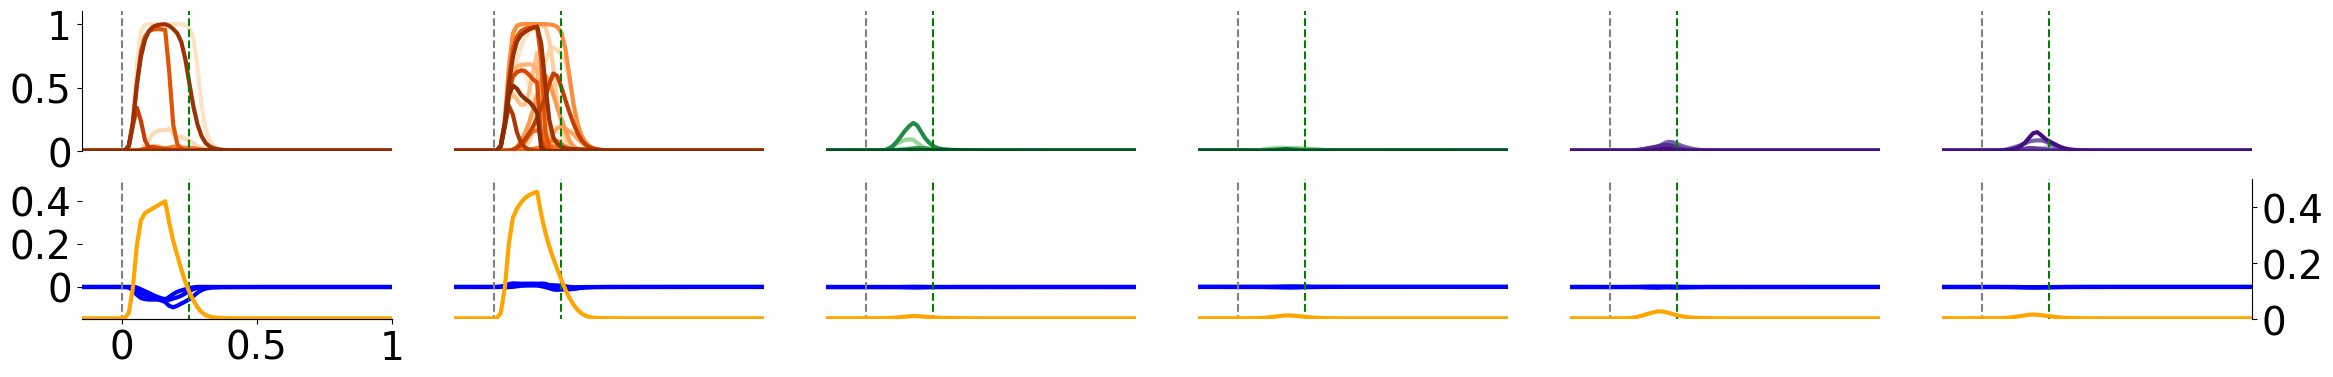

In [121]:
#hereee

time = results_seq['time']
r_ctx = results_seq['rates_ctx']
overlaps = results_seq['overlaps_sym']


ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 28
lw_fr = 3 
lw_ov = 3

#hereee

time = results_seq['time']
r_ctx = results_seq['rates_ctx']
overlaps = results_seq['overlaps_sym']


ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 28
lw_fr = 3 
lw_ov = 3

dt = modelparams['dt']
t_start = modelparams['t_start']
deltat = modelparams['t_stim'] #time before stimulus
t_stop = t_start + 1
t_end = t_stop


colors_oranges = plt.cm.Oranges(np.linspace(0,1, N_neu))
colors_purples = plt.cm.Purples(np.linspace(0, 1 , N_neu))
colors_greens = plt.cm.Greens(np.linspace(0, 1 , N_neu))

fig, ax = plt.subplots(figsize=(28, 4),nrows=2, ncols=6)

dN = 10
s = 0
#frist column
color_obs = 'green'
x_obs = t_start+0.25
ind1 = names_ctx.index('V1')
for l in range(ind1* N_neu, (ind1+1)* N_neu, dN):
    ax[0,0].plot(time, r_ctx[:, l], color = colors_oranges[l-ind1* N_neu], lw= lw_fr)
ax[0,0].set_ylim([0,1.1])
ax[0,0].set_xticks([])
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['bottom'].set_visible(False)
#ax[0,0].spines['left'].set_visible(False)
ax[0,0].set_xlim([t_start-deltat, t_end])
#ax[0,0].set_yticks([])
ax[0,0].set_yticks([0, 0.5, 1])
ax[0,0].set_yticklabels([0, 0.5, 1], fontsize = s_ticks)
ax[0,0].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,0].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )


#for k in range(overlaps.shape[3]):
ax[1,0].plot(time, overlaps[:, ind1, s, :], color = 'b', lw= lw_ov)
ax[1,0].set_ylim([-.15,0.5])
ax[1,0].set_xlim([t_end - 2, t_end])
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
#ax[1,0].spines['bottom'].set_visible(False)
ax[1,0].set_xlim([t_start-deltat, t_end])
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,0].set_xticks([t_start, t_start+0.5, t_start+1])
ax[1,0].set_xticklabels([ 0,  0.5, 1], fontsize = s_ticks)
ax[1,0].set_yticks([0, 0.2, 0.4])
ax[1,0].set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)
ax[1,0].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,0].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )

ax10 = ax[1,0].twinx()
r_mean1 = np.mean(r_ctx[:, ind1* N_neu: (ind1+1)* N_neu], axis = 1)
ax10.plot(time,  r_mean1, color = m_fr_color, lw= lw_ov)
ax10.set_ylim([0,0.5])
ax10.set_xlim([t_start-deltat, t_end])
ax10.set_xticks([t_start, t_start+0.5, t_start+1])
ax10.set_xticklabels([0,  0.5, 1], fontsize = s_ticks)
ax10.spines['right'].set_visible(False)
ax10.spines['top'].set_visible(False)
#ax10.spines['bottom'].set_visible(False)
ax10.spines['left'].set_visible(False)
ax10.set_yticks([])
#ax10.set_xticks([])

#second column

ind2 = names_ctx.index('V4') 
for l in range(ind2* N_neu, (ind2+1)* N_neu, dN):
    ax[0,1].plot(time, r_ctx[:, l],  color = colors_oranges[l - ind2* N_neu], lw= lw_fr)
ax[0,1].set_ylim([0,1.1])
ax[0,1].set_xticks([])
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].spines['bottom'].set_visible(False)
ax[0,1].set_xlim([t_start-deltat, t_end])
ax[0,1].set_yticks([])
ax[0,1].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,1].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )




ax[1,1].plot(time, overlaps[:, ind2, s, :], color = 'b', lw= lw_ov)
#ax[1,1].plot(time, overlaps[:, ind2, 0], color = ov_color, lw= lw_ov)
ax[1,1].set_ylim([-.15,0.5])
ax[1,1].set_xlim([t_end - 2, t_end])
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].spines['bottom'].set_visible(False)
ax[1,1].set_yticks([])
ax[1,1].set_xlim([t_start-deltat, t_end])
ax[1,1].set_xticks([])
#ax[1,1].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,1].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1,1].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,1].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )



ax11 = ax[1,1].twinx()
r_mean = np.mean(r_ctx[:, ind2 * N_neu: (ind2+1) * N_neu], axis = 1)
ax11.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax11.set_ylim([0,0.5])
ax11.set_xlim([t_start-deltat, t_end])
ax11.set_xticks([])
#ax11.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax11.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax11.spines['top'].set_visible(False)
ax11.spines['left'].set_visible(False)
ax11.spines['right'].set_visible(False)
ax11.spines['bottom'].set_visible(False)
ax11.set_yticks([])

#third column

ind3 =  names_ctx.index('LB')#
for l in range(ind3* N_neu, (ind3+1)* N_neu, dN):
    ax[0,2].plot(time, r_ctx[:, l], color = colors_greens[l-ind3* N_neu], lw=lw_fr)
ax[0,2].set_ylim([0,1.1])
ax[0,2].set_xticks([])
ax[0,2].spines['right'].set_visible(False)
ax[0,2].spines['top'].set_visible(False)
ax[0,2].spines['left'].set_visible(False)
ax[0,2].spines['bottom'].set_visible(False)
ax[0,2].set_yticks([])
ax[0,2].set_xlim([t_start-deltat, t_end])
ax[0,2].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,2].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )

ax[1,2].plot(time, overlaps[:, ind3, s, :], color = 'b', lw= lw_ov)
ax[1,2].set_ylim([-.15,0.5])
ax[1,2].spines['right'].set_visible(False)
ax[1,2].spines['top'].set_visible(False)
ax[1,2].spines['left'].set_visible(False)
ax[1,2].spines['bottom'].set_visible(False)
ax[1,2].set_yticks([])
ax[1,2].set_xlim([t_start-deltat, t_end])
ax[1,2].set_xticks([])
#ax[1,2].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,2].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1,2].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,2].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )

ax12 = ax[1,2].twinx()
r_mean = np.mean(r_ctx[:, ind3* N_neu: (ind3+1)* N_neu], axis = 1)
ax12.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax12.set_ylim([0,.5])
ax12.set_xlim([t_start-deltat, t_end])
ax12.set_xticks([])
#ax12.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax12.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
#ax12.spines['right'].set_visible(False)
ax12.spines['top'].set_visible(False)
ax12.spines['left'].set_visible(False)
ax12.spines['right'].set_visible(False)
ax12.spines['bottom'].set_visible(False)
ax12.set_yticks([])
#ax12.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)


#4th column
ind3 = names_ctx.index('PBr')#
for l in range(ind3* N_neu, (ind3+1)* N_neu, dN):
    ax[0,3].plot(time, r_ctx[:, l], color = colors_greens[l-ind3* N_neu], lw=lw_fr)
ax[0,3].set_ylim([0,1.1])
ax[0,3].set_xticks([])
ax[0,3].spines['right'].set_visible(False)
ax[0,3].spines['top'].set_visible(False)
ax[0,3].spines['left'].set_visible(False)
ax[0,3].spines['bottom'].set_visible(False)
ax[0,3].set_yticks([])
ax[0,3].set_xlim([t_start-deltat, t_end])
ax[0,3].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,3].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )

ax[1,3].plot(time, overlaps[:, ind3, s, :], color = 'b', lw= lw_ov)
#ax[1,3].plot(time, overlaps[:, ind3, 1], color = ov_color, lw= lw_ov)
ax[1,3].set_ylim([-.15,0.5])
ax[1,3].set_xlim([t_start-deltat, t_end])
ax[1,3].set_xticks([])
#ax[1,3].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,3].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1,3].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,3].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )
ax[1,3].spines['right'].set_visible(False)
ax[1,3].spines['top'].set_visible(False)
ax[1,3].spines['left'].set_visible(False)
ax[1,3].spines['bottom'].set_visible(False)
ax[1,3].set_yticks([])


ax13 = ax[1,3].twinx()
r_mean = np.mean(r_ctx[:, ind3* N_neu: (ind3+1)* N_neu], axis = 1)
ax13.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax13.set_ylim([0,.5])
ax13.set_xlim([t_start-deltat, t_end])
ax13.set_xticks([])
#ax13.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax13.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax13.spines['top'].set_visible(False)
ax13.spines['left'].set_visible(False)
ax13.spines['right'].set_visible(False)
ax13.spines['bottom'].set_visible(False)
ax13.set_yticks([])


#5th column

ind3 = names_ctx.index('23')
for l in range(ind3* N_neu, (ind3+1)* N_neu, dN):
    ax[0,4].plot(time, r_ctx[:, l], color = colors_purples[l-ind3* N_neu], lw=lw_fr)
ax[0,4].set_ylim([0,1.1])
ax[0,4].set_xticks([])
ax[0,4].spines['right'].set_visible(False)
ax[0,4].spines['top'].set_visible(False)
ax[0,4].spines['left'].set_visible(False)
ax[0,4].spines['bottom'].set_visible(False)
ax[0,4].set_xlim([t_start-deltat, t_end])
ax[0,4].set_yticks([])
ax[0,4].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,4].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )


ax[1,4].plot(time, overlaps[:, ind3, s, :], color = 'b', lw= lw_ov)
ax[1,4].set_ylim([-.15,0.5])
ax[1,4].set_xlim([t_end - 2, t_end])
ax[1,4].spines['right'].set_visible(False)
ax[1,4].spines['top'].set_visible(False)
ax[1,4].spines['left'].set_visible(False)
ax[1,4].spines['bottom'].set_visible(False)
ax[1,4].set_yticks([])
ax[1,4].set_xlim([t_start-deltat, t_end])
ax[1,4].set_xticks([])
#ax[1,4].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,4].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1,4].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,4].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )


ax14 = ax[1,4].twinx()
r_mean = np.mean(r_ctx[:, ind3* N_neu: (ind3+1)* N_neu], axis = 1)
ax14.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax14.set_ylim([0,.5])
ax14.set_xlim([t_start-deltat, t_end])
ax14.set_xticks([])
#ax14.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax14.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax14.spines['right'].set_visible(False)
ax14.spines['top'].set_visible(False)
ax14.spines['left'].set_visible(False)
ax14.spines['bottom'].set_visible(False)
ax14.set_yticks([])

#6th column
ind6 = names_ctx.index('INS')
for l in range(ind6 * N_neu, (ind6 + 1)* N_neu, dN):
    ax[0,5].plot(time, r_ctx[:, l], color = colors_purples[l-ind6* N_neu], lw=lw_fr)
ax[0,5].set_ylim([0,1.1])
ax[0,5].set_xticks([])
ax[0,5].spines['right'].set_visible(False)
ax[0,5].spines['top'].set_visible(False)
ax[0,5].spines['left'].set_visible(False)
ax[0,5].spines['bottom'].set_visible(False)
ax[0,5].set_xlim([t_start-deltat, t_end])
ax[0,5].set_yticks([])
ax[0,5].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[0,5].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )

ax[1,5].plot(time, overlaps[:, ind6, s, :], color = 'b', lw= lw_ov)
ax[1,5].set_ylim([-.15,0.5])
ax[1,5].set_xlim([t_end - 2, t_end])
ax[1,5].spines['right'].set_visible(False)
ax[1,5].spines['top'].set_visible(False)
ax[1,5].spines['left'].set_visible(False)
ax[1,5].spines['bottom'].set_visible(False)
ax[1,5].set_yticks([])
ax[1,5].set_xlim([t_start-deltat, t_end])
ax[1,5].set_xticks([])
#ax[1,5].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,5].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1,5].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
ax[1,5].axvline(x=x_obs, ymin=-1, ymax=1, ls = '--',color=color_obs )
#ax[1,5].axhline(y=0, xmin=0, xmax=400, ls = '--',color='gray')

ax15 = ax[1,5].twinx()
r_mean = np.mean(r_ctx[:, ind6 * N_neu: (ind6 + 1)* N_neu], axis = 1)
ax15.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax15.set_ylim([0,.5])
ax15.set_xlim([t_start-deltat, t_end])
ax15.set_xticks([])
#ax15.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax15.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
#ax12.spines['right'].set_visible(False)
ax15.spines['top'].set_visible(False)
ax15.spines['left'].set_visible(False)
ax15.spines['bottom'].set_visible(False)
#ax15.spines['right'].set_visible(False)
ax15.set_yticks([0, 0.2, 0.4])
ax15.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)
#ax15.set_yticks([])




plt.savefig('figures/panels/salience_random_visual.pdf', bbox_inches='tight')

In [122]:
if True:
    #save as mat file
    overlaps = results_seq['overlaps_sym'][:,:,0,:]
    sio.savemat('results/overlaps_salient_random_visual.mat', {'overlaps_salient_random_visual':overlaps})
    r_ctx = results_seq['rates_ctx']
    N_block = modelparams['N_block'] # resolution saved nurons 
    N_recorded = modelparams['N_recorded'] # resolution saved nurons 
    N_neu =int( N_block/int(N_block/N_recorded)) #number recorded neurons
    mean_rates = []
    for l in range(89):
        r_mean = np.mean(r_ctx[:, l * N_neu: (l + 1)* N_neu], axis = 1)
        mean_rates.append(r_mean)
    mean_rates = np.array(mean_rates)
    sio.savemat('results/mean_rate_salient_random_visual.mat', {'rate_salient_random_visual':mean_rates})
